#### Imports

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#### Plotting style

In [2]:
plt.style.use('seaborn-whitegrid')
sns.set_palette("husl")

#### Check for CUDA

In [3]:
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU Available: True
GPU Memory: 25.4 GB


#### Load + explore data

In [4]:
def load_dataset(file_path):
    """Load the JSONL dataset and return as list of dictionaries"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

In [5]:
def explore_dataset(data):
    """Analyze dataset composition and statistics"""
    df = pd.DataFrame(data)
    
    print("Dataset Overview:")
    print(f"Total examples: {len(data)}")
    print(f"Target types: {df['type'].unique()}")
    print(f"Type distribution:\n{df['type'].value_counts()}")
    
    # Analyze list lengths and answer distributions
    df['list_length'] = df['list'].apply(len)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution of list lengths
    axes[0,0].hist(df['list_length'], bins=20, alpha=0.7)
    axes[0,0].set_title('Distribution of List Lengths')
    axes[0,0].set_xlabel('List Length')
    axes[0,0].set_ylabel('Frequency')
    
    # Distribution of correct answers
    axes[0,1].hist(df['answer'], bins=20, alpha=0.7)
    axes[0,1].set_title('Distribution of Correct Answers')
    axes[0,1].set_xlabel('Number of Target Items')
    axes[0,1].set_ylabel('Frequency')
    
    # Answer distribution by type
    df.boxplot(column='answer', by='type', ax=axes[1,0])
    axes[1,0].set_title('Answer Distribution by Type')
    axes[1,0].set_xlabel('Type')
    axes[1,0].set_ylabel('Number of Target Items')
    
    # List length distribution by type
    df.boxplot(column='list_length', by='type', ax=axes[1,1])
    axes[1,1].set_title('List Length Distribution by Type')
    axes[1,1].set_xlabel('Type')
    axes[1,1].set_ylabel('List Length')
    
    plt.tight_layout()
    plt.show()
    
    return df

Dataset Overview:
Total examples: 5000
Target types: ['sports' 'animals' 'cities' 'fruits' 'professions']
Type distribution:
cities         1037
professions    1002
fruits          999
sports          992
animals         970
Name: type, dtype: int64


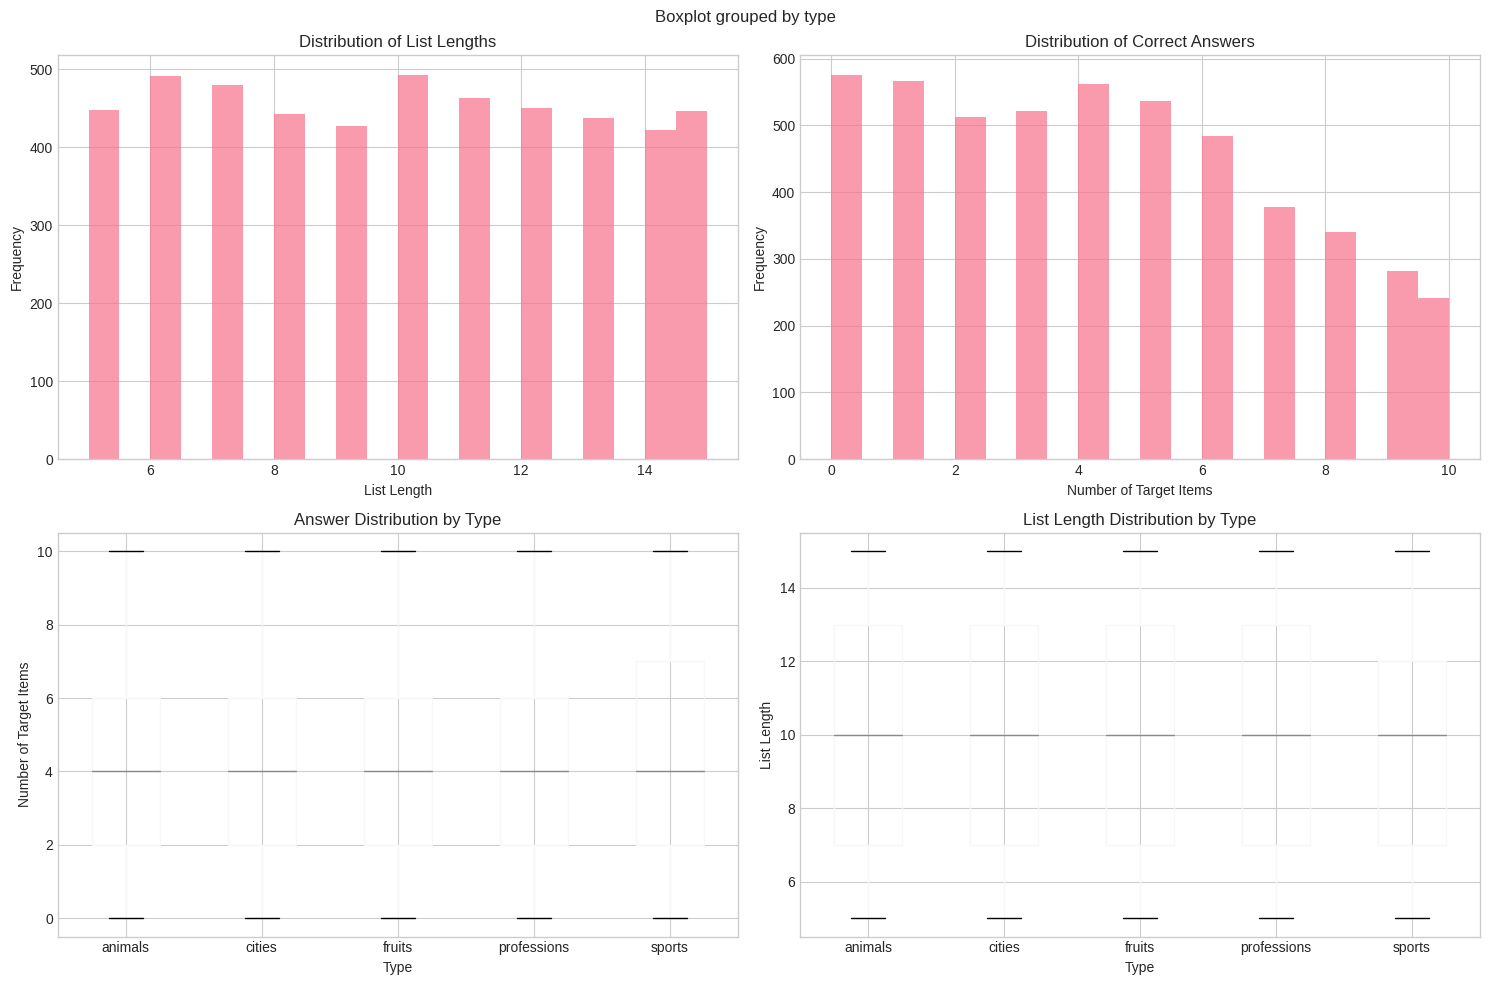

In [6]:
data = load_dataset('word_counting_dataset.jsonl')
df = explore_dataset(data)

#### Model configurations

In [7]:
HF_TOKEN=""

In [8]:
# Models to evaluate
MODELS_TO_TEST = [
    "mistralai/Mistral-7B-Instruct-v0.3",
    "meta-llama/Llama-3.2-3B-Instruct",
    "openai-community/gpt2-large",
    "tiiuae/Falcon3-7B-Instruct",
    # Add more models as needed
]

In [9]:
# Evaluation settings
MAX_NEW_TOKENS = 5  # We only need a short answer like "(3)"
TEMPERATURE = 0.0    # Deterministic generation
DO_SAMPLE = False

#### Engineer prompts

In [10]:
def create_prompt(example):
    """Create a formatted prompt for the word counting task"""
    list_str = " ".join(example['list'])
    
    prompt = f"""Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: {example['type']}
    List: [{list_str}]
    Answer: ("""
    
    return prompt

In [11]:
def create_few_shot_prompt(example, few_shot_examples=None):
    """Create a few-shot prompt with examples"""
    if few_shot_examples is None:
        return create_prompt(example)
    
    prompt = ""
    for fs_example in few_shot_examples:
        list_str = " ".join(fs_example['list'])
        prompt += f"""Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
        Type: {fs_example['type']}
        List: [{list_str}]
        Answer: ({fs_example['answer']})
        """
    
    # Add the actual example
    list_str = " ".join(example['list'])
    prompt += f"""Count the number of words in the following list that match the given type, and put the numerical answer in parentheses.
    Type: {example['type']}
    List: [{list_str}]
    Answer: ("""
    
    return prompt

#### Model loading and evaluations

In [12]:
class LLMEvaluator:
    def __init__(self, model_name, device='cuda'):
        self.model_name = model_name
        self.device = device
        self.model = None
        self.tokenizer = None
        
    def load_model(self):
        """Load model and tokenizer"""
        print(f"Loading {self.model_name}...")
        
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name,token=HF_TOKEN)
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16,
                device_map="auto",
                trust_remote_code=True,
                token=HF_TOKEN
            )
            
            # Add pad token if not present
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                
            print(f"✓ Successfully loaded {self.model_name}")
            
        except Exception as e:
            print(f"✗ Failed to load {self.model_name}: {str(e)}")
            raise
    
    def generate_response(self, prompt):
        """Generate response for a single prompt"""
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE,
                do_sample=DO_SAMPLE,
                pad_token_id=self.tokenizer.eos_token_id
            )
        
        # Decode only the new tokens
        new_tokens = outputs[0][inputs['input_ids'].shape[1]:]
        response = self.tokenizer.decode(new_tokens, skip_special_tokens=True)
        
        return response.strip()
    
    def evaluate_dataset(self, data, max_examples=None, few_shot_examples=None):
        """Evaluate model on the entire dataset"""
        if max_examples:
            data = data[:max_examples]
            
        results = []
        
        for i, example in enumerate(tqdm(data, desc=f"Evaluating {self.model_name}")):
            try:
                # Create prompt
                if few_shot_examples:
                    prompt = create_few_shot_prompt(example, few_shot_examples)
                else:
                    prompt = create_prompt(example)
                
                # Generate response
                response = self.generate_response(prompt)
                
                # Parse answer
                predicted_answer = self.parse_answer(response)
                
                result = {
                    'example_id': i,
                    'type': example['type'],
                    'list_length': len(example['list']),
                    'correct_answer': example['answer'],
                    'raw_response': response,
                    'predicted_answer': predicted_answer,
                    'correct': predicted_answer == example['answer'],
                    'model': self.model_name
                }
                
                results.append(result)
                
            except Exception as e:
                print(f"Error processing example {i}: {str(e)}")
                results.append({
                    'example_id': i,
                    'type': example['type'],
                    'list_length': len(example['list']),
                    'correct_answer': example['answer'],
                    'raw_response': f"ERROR: {str(e)}",
                    'predicted_answer': -1,
                    'correct': False,
                    'model': self.model_name
                })
        
        return pd.DataFrame(results)
    
    def parse_answer(self, response):
        """Extract numerical answer from model response"""
        # Look for patterns like "3)" or just "3"
        import re
        
        # First, try to find number in parentheses pattern
        match = re.search(r'(\d+)\)', response)
        if match:
            return int(match.group(1))
        
        # If not found, look for any number
        match = re.search(r'\d+', response)
        if match:
            return int(match.group())
        
        # If no number found, return -1 to indicate parsing failure
        return -1
    
    def unload_model(self):
        """Free up GPU memory"""
        if self.model is not None:
            del self.model
            del self.tokenizer
            torch.cuda.empty_cache()
            print(f"✓ Unloaded {self.model_name}")

#### Evaluation pipeline

In [13]:
def run_evaluation(data, models_to_test=None, max_examples_per_model=100, 
                  save_results=True, few_shot_examples=None):
    """Run evaluation on multiple models"""
    
    if models_to_test is None:
        models_to_test = MODELS_TO_TEST
    
    all_results = []
    
    for model_name in models_to_test:
        print(f"\n{'='*50}")
        print(f"Evaluating: {model_name}")
        print(f"{'='*50}")
        
        try:
            evaluator = LLMEvaluator(model_name)
            evaluator.load_model()
            
            # Run evaluation
            model_results = evaluator.evaluate_dataset(
                data, 
                max_examples=max_examples_per_model,
                few_shot_examples=few_shot_examples
            )
            
            all_results.append(model_results)
            
            # Print quick summary
            accuracy = model_results['correct'].mean()
            print(f"Accuracy: {accuracy:.3f} ({model_results['correct'].sum()}/{len(model_results)})")
            
            # Clean up memory
            evaluator.unload_model()
            
        except Exception as e:
            print(f"Failed to evaluate {model_name}: {str(e)}")
            continue
    
    # Combine all results
    if all_results:
        combined_results = pd.concat(all_results, ignore_index=True)
        
        if save_results:
            timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
            filename = f'evaluation_results_{timestamp}.csv'
            combined_results.to_csv(filename, index=False)
            print(f"\n✓ Results saved to {filename}")
        
        return combined_results
    else:
        print("No results to return - all models failed")
        return None

#### Result analysis and visualizations

In [14]:
def analyze_results(results_df):
    """Comprehensive analysis of evaluation results"""
    
    print("="*60)
    print("EVALUATION RESULTS ANALYSIS")
    print("="*60)
    
    # Overall accuracy by model
    model_accuracy = results_df.groupby('model')['correct'].agg(['mean', 'count', 'sum']).round(3)
    model_accuracy.columns = ['Accuracy', 'Total_Examples', 'Correct_Examples']
    print("\nOverall Accuracy by Model:")
    print(model_accuracy.sort_values('Accuracy', ascending=False))
    
    # Accuracy by type
    print("\nAccuracy by Target Type:")
    type_accuracy = results_df.groupby(['model', 'type'])['correct'].mean().unstack(fill_value=0).round(3)
    print(type_accuracy)
    
    # Accuracy by answer value (difficulty analysis)
    print("\nAccuracy by Number of Target Items (Difficulty Analysis):")
    answer_accuracy = results_df.groupby(['model', 'correct_answer'])['correct'].mean().unstack(fill_value=0).round(3)
    print(answer_accuracy)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Overall accuracy comparison
    model_acc = results_df.groupby('model')['correct'].mean().sort_values(ascending=True)
    model_acc.plot(kind='barh', ax=axes[0,0])
    axes[0,0].set_title('Overall Accuracy by Model')
    axes[0,0].set_xlabel('Accuracy')
    
    # 2. Accuracy by type (heatmap)
    type_pivot = results_df.groupby(['model', 'type'])['correct'].mean().unstack(fill_value=0)
    sns.heatmap(type_pivot, annot=True, fmt='.3f', ax=axes[0,1], cmap='RdYlGn')
    axes[0,1].set_title('Accuracy by Target Type')
    
    # 3. Accuracy by answer value
    answer_pivot = results_df.groupby(['model', 'correct_answer'])['correct'].mean().unstack(fill_value=0)
    sns.heatmap(answer_pivot, annot=True, fmt='.3f', ax=axes[0,2], cmap='RdYlGn')
    axes[0,2].set_title('Accuracy by Number of Target Items')
    
    # 4. Distribution of errors
    error_data = results_df[~results_df['correct']]
    if len(error_data) > 0:
        error_data.groupby('model')['type'].value_counts().unstack(fill_value=0).plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Error Distribution by Type')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Parsing failure analysis
    parsing_failures = results_df[results_df['predicted_answer'] == -1]
    if len(parsing_failures) > 0:
        parsing_failures.groupby('model').size().plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Parsing Failures by Model')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. List length vs accuracy
    length_acc = results_df.groupby(['model', 'list_length'])['correct'].mean().unstack(fill_value=0)
    if len(length_acc.columns) > 1:
        length_acc.T.plot(ax=axes[1,2], marker='o')
        axes[1,2].set_title('Accuracy vs List Length')
        axes[1,2].set_xlabel('List Length')
        axes[1,2].set_ylabel('Accuracy')
        axes[1,2].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return model_accuracy, type_accuracy, answer_accuracy

In [15]:
def analyze_error_patterns(results_df):
    """Detailed analysis of error patterns"""
    errors = results_df[~results_df['correct']].copy()
    
    if len(errors) == 0:
        print("No errors to analyze!")
        return
    
    print("\n" + "="*50)
    print("ERROR PATTERN ANALYSIS")
    print("="*50)
    
    # Calculate prediction bias
    errors['prediction_error'] = errors['predicted_answer'] - errors['correct_answer']
    
    print(f"\nTotal errors: {len(errors)}")
    print(f"Parsing failures: {len(errors[errors['predicted_answer'] == -1])}")
    
    # Prediction bias analysis
    valid_errors = errors[errors['predicted_answer'] != -1]
    if len(valid_errors) > 0:
        print(f"Mean prediction error: {valid_errors['prediction_error'].mean():.3f}")
        print(f"Std prediction error: {valid_errors['prediction_error'].std():.3f}")
        
        # Show common error patterns
        print("\nMost common raw responses for errors:")
        print(errors['raw_response'].value_counts().head(10))

In [16]:
def save_individual_plots(results_df, output_dir='plots'):
    """Save individual plots as high-resolution files"""
    import os
    from datetime import datetime
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Set larger figure size for better readability
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 12
    
    # 1. Overall accuracy comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    model_acc = results_df.groupby('model')['correct'].mean().sort_values(ascending=True)
    model_acc.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title('Overall Accuracy by Model', fontsize=16, fontweight='bold')
    ax.set_xlabel('Accuracy', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/overall_accuracy_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Accuracy by type (heatmap)
    fig, ax = plt.subplots(figsize=(10, 8))
    type_pivot = results_df.groupby(['model', 'type'])['correct'].mean().unstack(fill_value=0)
    sns.heatmap(type_pivot, annot=True, fmt='.3f', ax=ax, cmap='RdYlGn', 
                cbar_kws={'label': 'Accuracy'})
    ax.set_title('Accuracy by Target Type', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/accuracy_by_type_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Accuracy by answer value
    fig, ax = plt.subplots(figsize=(12, 8))
    answer_pivot = results_df.groupby(['model', 'correct_answer'])['correct'].mean().unstack(fill_value=0)
    sns.heatmap(answer_pivot, annot=True, fmt='.3f', ax=ax, cmap='RdYlGn',
                cbar_kws={'label': 'Accuracy'})
    ax.set_title('Accuracy by Number of Target Items', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Target Items', fontsize=14)
    ax.set_ylabel('Model', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/accuracy_by_answer_count_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. List length vs accuracy
    fig, ax = plt.subplots(figsize=(12, 8))
    length_acc = results_df.groupby(['model', 'list_length'])['correct'].mean().unstack(fill_value=0)
    if len(length_acc.columns) > 1:
        length_acc.T.plot(ax=ax, marker='o', linewidth=2, markersize=6)
        ax.set_title('Accuracy vs List Length', fontsize=16, fontweight='bold')
        ax.set_xlabel('List Length', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)
        ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/accuracy_vs_list_length_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Error distribution by type
    error_data = results_df[~results_df['correct']]
    if len(error_data) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        error_counts = error_data.groupby('model')['type'].value_counts().unstack(fill_value=0)
        error_counts.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title('Error Distribution by Type', fontsize=16, fontweight='bold')
        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel('Number of Errors', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Target Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/error_distribution_{timestamp}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # 6. Parsing failures
    parsing_failures = results_df[results_df['predicted_answer'] == -1]
    if len(parsing_failures) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        parsing_failures.groupby('model').size().plot(kind='bar', ax=ax, color='coral')
        ax.set_title('Parsing Failures by Model', fontsize=16, fontweight='bold')
        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel('Number of Parsing Failures', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/parsing_failures_{timestamp}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"✓ Individual plots saved to '{output_dir}/' directory")
    print(f"  Files timestamped with: {timestamp}")

#### Example usage

In [17]:
def main():
    """Main execution function - run this to start evaluation"""
    
    # Load dataset
    print("Loading dataset...")
    loaded_data = load_dataset('word_counting_dataset.jsonl')  # Update path
    # df = explore_dataset(data)
    
    # For demonstration, create sample data structure
    # Remove this section when you have real data
    # print("Creating sample data for demonstration...")
    # sample_data = [
    #     {"type": "fruit", "list": ["apple", "chair", "banana", "dog"], "answer": 2},
    #     {"type": "animals", "list": ["cat", "tree", "dog", "lion", "book"], "answer": 3},
    #     {"type": "cities", "list": ["paris", "apple", "london", "car"], "answer": 2},
    # ]
    
    # Run evaluation
    print("\nStarting evaluation...")
    results = run_evaluation(
        data=loaded_data,  # Replace with your loaded data
        models_to_test=MODELS_TO_TEST[:],  # Start with 2 models for testing
        max_examples_per_model=5000,  # Start small for testing
        save_results=True
    )
    
    if results is not None:
        # Analyze results
        model_acc, type_acc, answer_acc = analyze_results(results)
        analyze_error_patterns(results)
        save_individual_plots(results)
        
        return results
    else:
        print("Evaluation failed - no results to analyze")
        return None

#### Few shot vs Zero shot analysis

In [18]:
# def prepare_few_shot_examples(data, n_examples=3):
#     """Prepare few-shot examples from the dataset"""
#     # Select balanced examples across types
#     few_shot = []
#     types = list(set([ex['type'] for ex in data]))
    
#     for typ in types[:n_examples]:
#         examples_of_type = [ex for ex in data if ex['type'] == typ]
#         if examples_of_type:
#             few_shot.append(examples_of_type[0])
    
#     return few_shot[:n_examples]

# def compare_zero_shot_vs_few_shot(data, models_to_test=None, max_examples=50):
#     """Compare zero-shot vs few-shot performance"""
    
#     few_shot_examples = prepare_few_shot_examples(data, n_examples=3)
    
#     print("Running zero-shot evaluation...")
#     zero_shot_results = run_evaluation(
#         data, models_to_test, max_examples, 
#         save_results=False, few_shot_examples=None
#     )
    
#     print("Running few-shot evaluation...")
#     few_shot_results = run_evaluation(
#         data, models_to_test, max_examples, 
#         save_results=False, few_shot_examples=few_shot_examples
#     )
    
#     if zero_shot_results is not None and few_shot_results is not None:
#         # Compare results
#         zero_shot_acc = zero_shot_results.groupby('model')['correct'].mean()
#         few_shot_acc = few_shot_results.groupby('model')['correct'].mean()
        
#         comparison = pd.DataFrame({
#             'Zero-Shot': zero_shot_acc,
#             'Few-Shot': few_shot_acc,
#             'Improvement': few_shot_acc - zero_shot_acc
#         }).round(3)
        
#         print("\nZero-shot vs Few-shot Comparison:")
#         print(comparison)
        
#         return zero_shot_results, few_shot_results, comparison
    
#     return None, None, None

Loading dataset...

Starting evaluation...

Evaluating: mistralai/Mistral-7B-Instruct-v0.3
Loading mistralai/Mistral-7B-Instruct-v0.3...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Successfully loaded mistralai/Mistral-7B-Instruct-v0.3


Evaluating mistralai/Mistral-7B-Instruct-v0.3:   0%|   | 0/5000 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Evaluating mistralai/Mistral-7B-Instruct-v0.3: 100%|█| 5000/5000 [12:01<00:00,  


Accuracy: 0.230 (1152/5000)
✓ Unloaded mistralai/Mistral-7B-Instruct-v0.3

Evaluating: meta-llama/Llama-3.2-3B-Instruct
Loading meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Successfully loaded meta-llama/Llama-3.2-3B-Instruct


Evaluating meta-llama/Llama-3.2-3B-Instruct: 100%|█| 5000/5000 [09:31<00:00,  8.


Accuracy: 0.188 (939/5000)
✓ Unloaded meta-llama/Llama-3.2-3B-Instruct

Evaluating: openai-community/gpt2-large
Loading openai-community/gpt2-large...
✓ Successfully loaded openai-community/gpt2-large


Evaluating openai-community/gpt2-large: 100%|█| 5000/5000 [09:15<00:00,  9.01it/


Accuracy: 0.093 (463/5000)
✓ Unloaded openai-community/gpt2-large

Evaluating: tiiuae/Falcon3-7B-Instruct
Loading tiiuae/Falcon3-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Successfully loaded tiiuae/Falcon3-7B-Instruct


Evaluating tiiuae/Falcon3-7B-Instruct: 100%|█| 5000/5000 [11:00<00:00,  7.57it/s


Accuracy: 0.292 (1461/5000)
✓ Unloaded tiiuae/Falcon3-7B-Instruct

✓ Results saved to evaluation_results_20250531_030418.csv
EVALUATION RESULTS ANALYSIS

Overall Accuracy by Model:
                                    Accuracy  Total_Examples  Correct_Examples
model                                                                         
tiiuae/Falcon3-7B-Instruct             0.292            5000              1461
mistralai/Mistral-7B-Instruct-v0.3     0.230            5000              1152
meta-llama/Llama-3.2-3B-Instruct       0.188            5000               939
openai-community/gpt2-large            0.093            5000               463

Accuracy by Target Type:
type                                animals  cities  fruits  professions  \
model                                                                      
meta-llama/Llama-3.2-3B-Instruct      0.182   0.162   0.260        0.155   
mistralai/Mistral-7B-Instruct-v0.3    0.202   0.236   0.294        0.233   
openai-communit

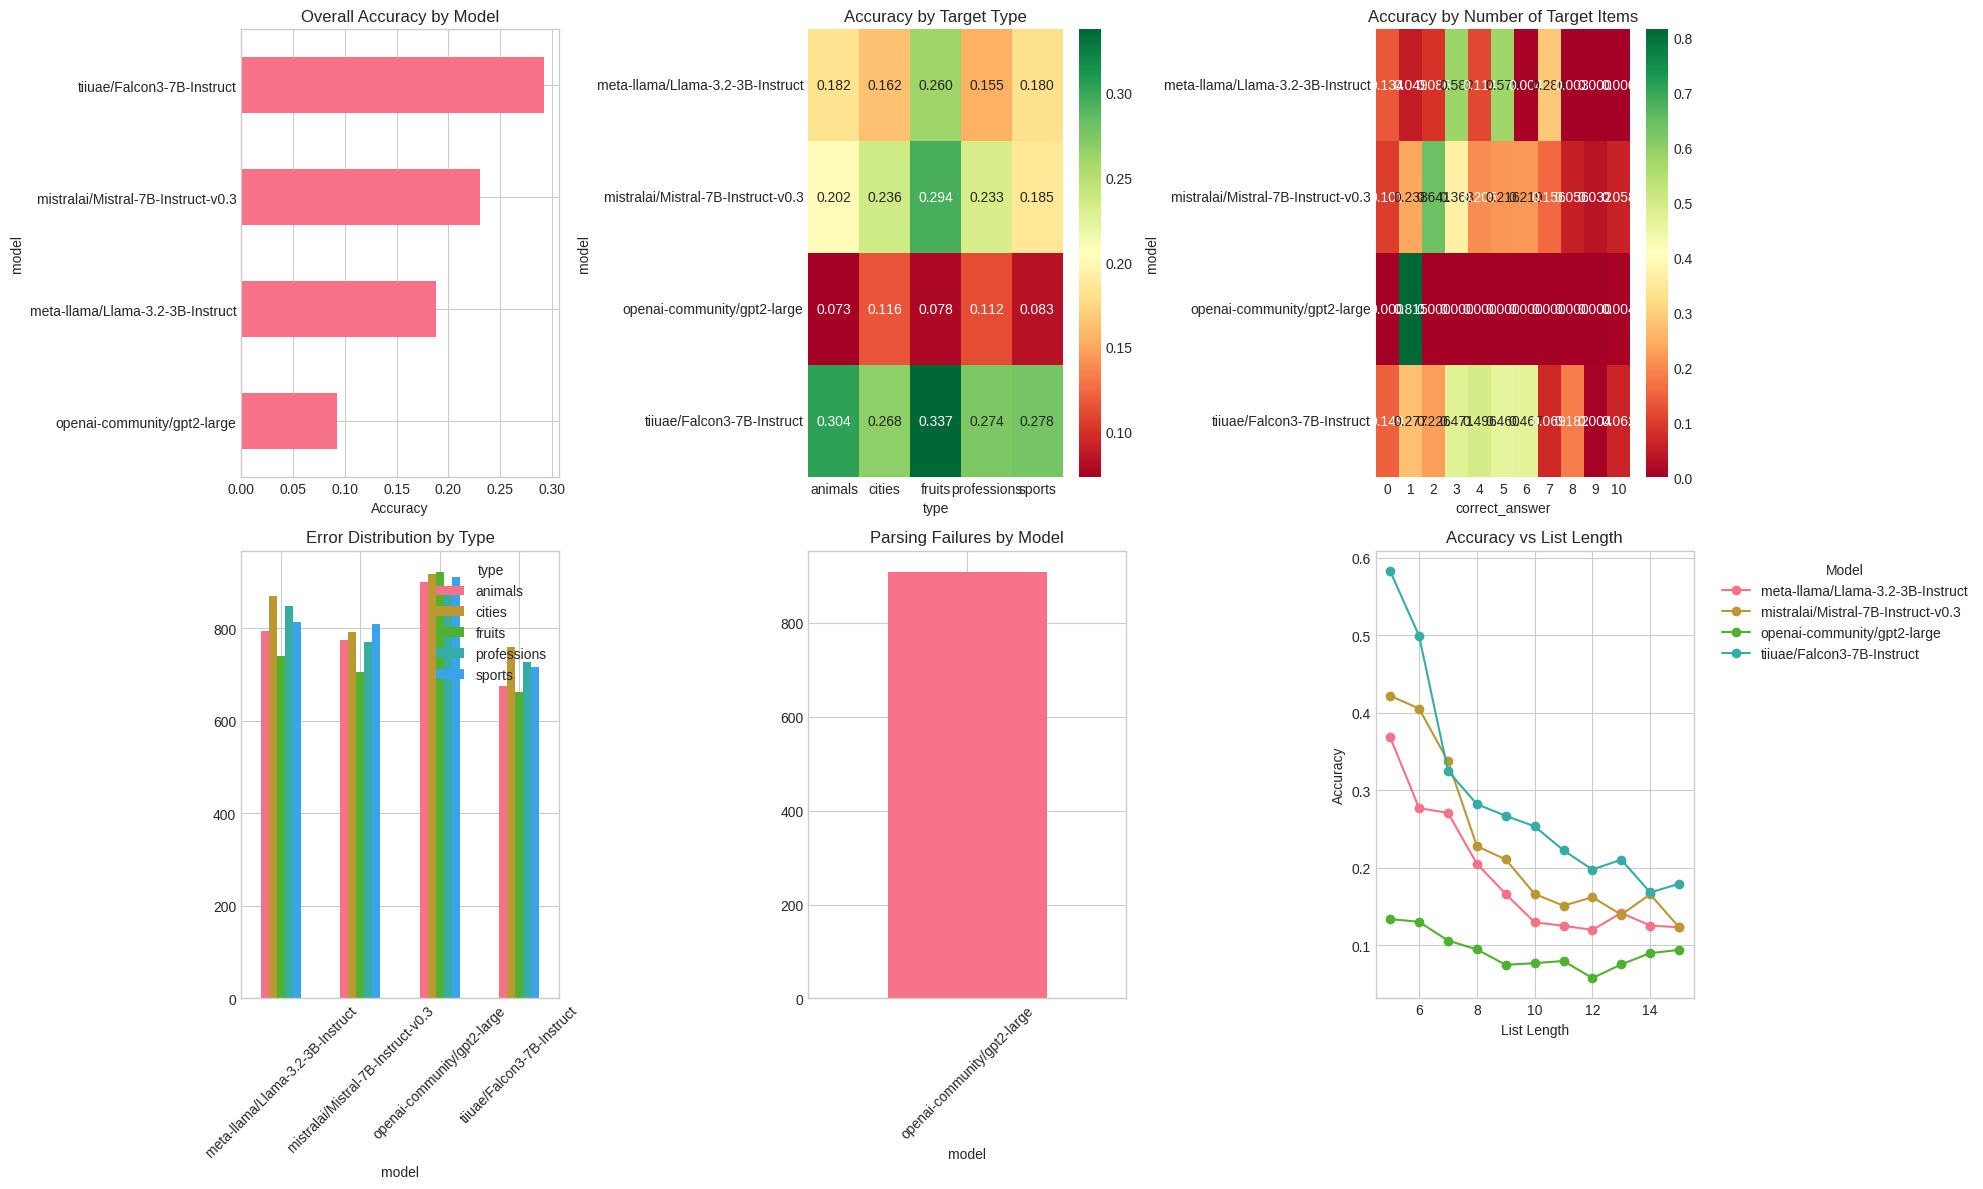


ERROR PATTERN ANALYSIS

Total errors: 15985
Parsing failures: 908
Mean prediction error: -0.976
Std prediction error: 2.740

Most common raw responses for errors:
1)                        3753
5)\n\nExplanation: The    1311
3)\n\nExplanation: The    1054
2)                        1044
3)                         942
7)\n\nExplanation: The     704
4)                         610
6)\n    <                  535
5)                         531
6)                         439
Name: raw_response, dtype: int64
✓ Individual plots saved to 'plots/' directory
  Files timestamped with: 20250531_030419
✓ Notebook setup complete!

To run the evaluation:
1. Update the dataset path in the load_dataset() call
2. Adjust MODELS_TO_TEST based on your preferences
3. Run: results = main()


In [19]:
# Uncomment to run the evaluation
results = main()

print("✓ Notebook setup complete!")
print("\nTo run the evaluation:")
print("1. Update the dataset path in the load_dataset() call")
print("2. Adjust MODELS_TO_TEST based on your preferences")
print("3. Run: results = main()")

#### Visualizations

In [20]:
# Cell 1: Function to display saved plots
from IPython.display import Image, display
import glob
import os

def display_saved_plots(plots_dir='plots', plot_type=None, latest_only=True):
    """Display saved plots in the notebook
    
    Args:
        plots_dir: Directory containing the plots
        plot_type: Specific plot type to show (e.g., 'overall_accuracy', 'accuracy_by_type')
        latest_only: If True, show only the most recent version of each plot type
    """
    if not os.path.exists(plots_dir):
        print(f"Plots directory '{plots_dir}' not found!")
        return
    
    # Get all PNG files
    if plot_type:
        pattern = f"{plots_dir}/{plot_type}_*.png"
    else:
        pattern = f"{plots_dir}/*.png"
    
    plot_files = glob.glob(pattern)
    plot_files.sort()  # Sort by filename (includes timestamp)
    
    if not plot_files:
        print("No plot files found!")
        return
    
    # If latest_only, get the most recent file for each plot type
    if latest_only:
        plot_dict = {}
        for file in plot_files:
            # Extract plot type from filename
            basename = os.path.basename(file)
            plot_name = '_'.join(basename.split('_')[:-2])  # Remove timestamp and .png
            plot_dict[plot_name] = file  # This will keep the latest due to sorting
        plot_files = list(plot_dict.values())
    
    # Display each plot
    for plot_file in plot_files:
        plot_name = os.path.basename(plot_file).replace('.png', '')
        print(f"\n{'='*60}")
        print(f"📊 {plot_name.replace('_', ' ').title()}")
        print(f"{'='*60}")
        display(Image(filename=plot_file, width=800))

def list_available_plots(plots_dir='plots'):
    """List all available plot types"""
    if not os.path.exists(plots_dir):
        print(f"Plots directory '{plots_dir}' not found!")
        return
    
    plot_files = glob.glob(f"{plots_dir}/*.png")
    plot_types = set()
    
    for file in plot_files:
        basename = os.path.basename(file)
        plot_type = '_'.join(basename.split('_')[:-2])  # Remove timestamp and .png
        plot_types.add(plot_type)
    
    print("Available plot types:")
    for i, plot_type in enumerate(sorted(plot_types), 1):
        print(f"{i}. {plot_type}")
    
    return sorted(plot_types)


📊 Accuracy By Answer Count 20250531 030419


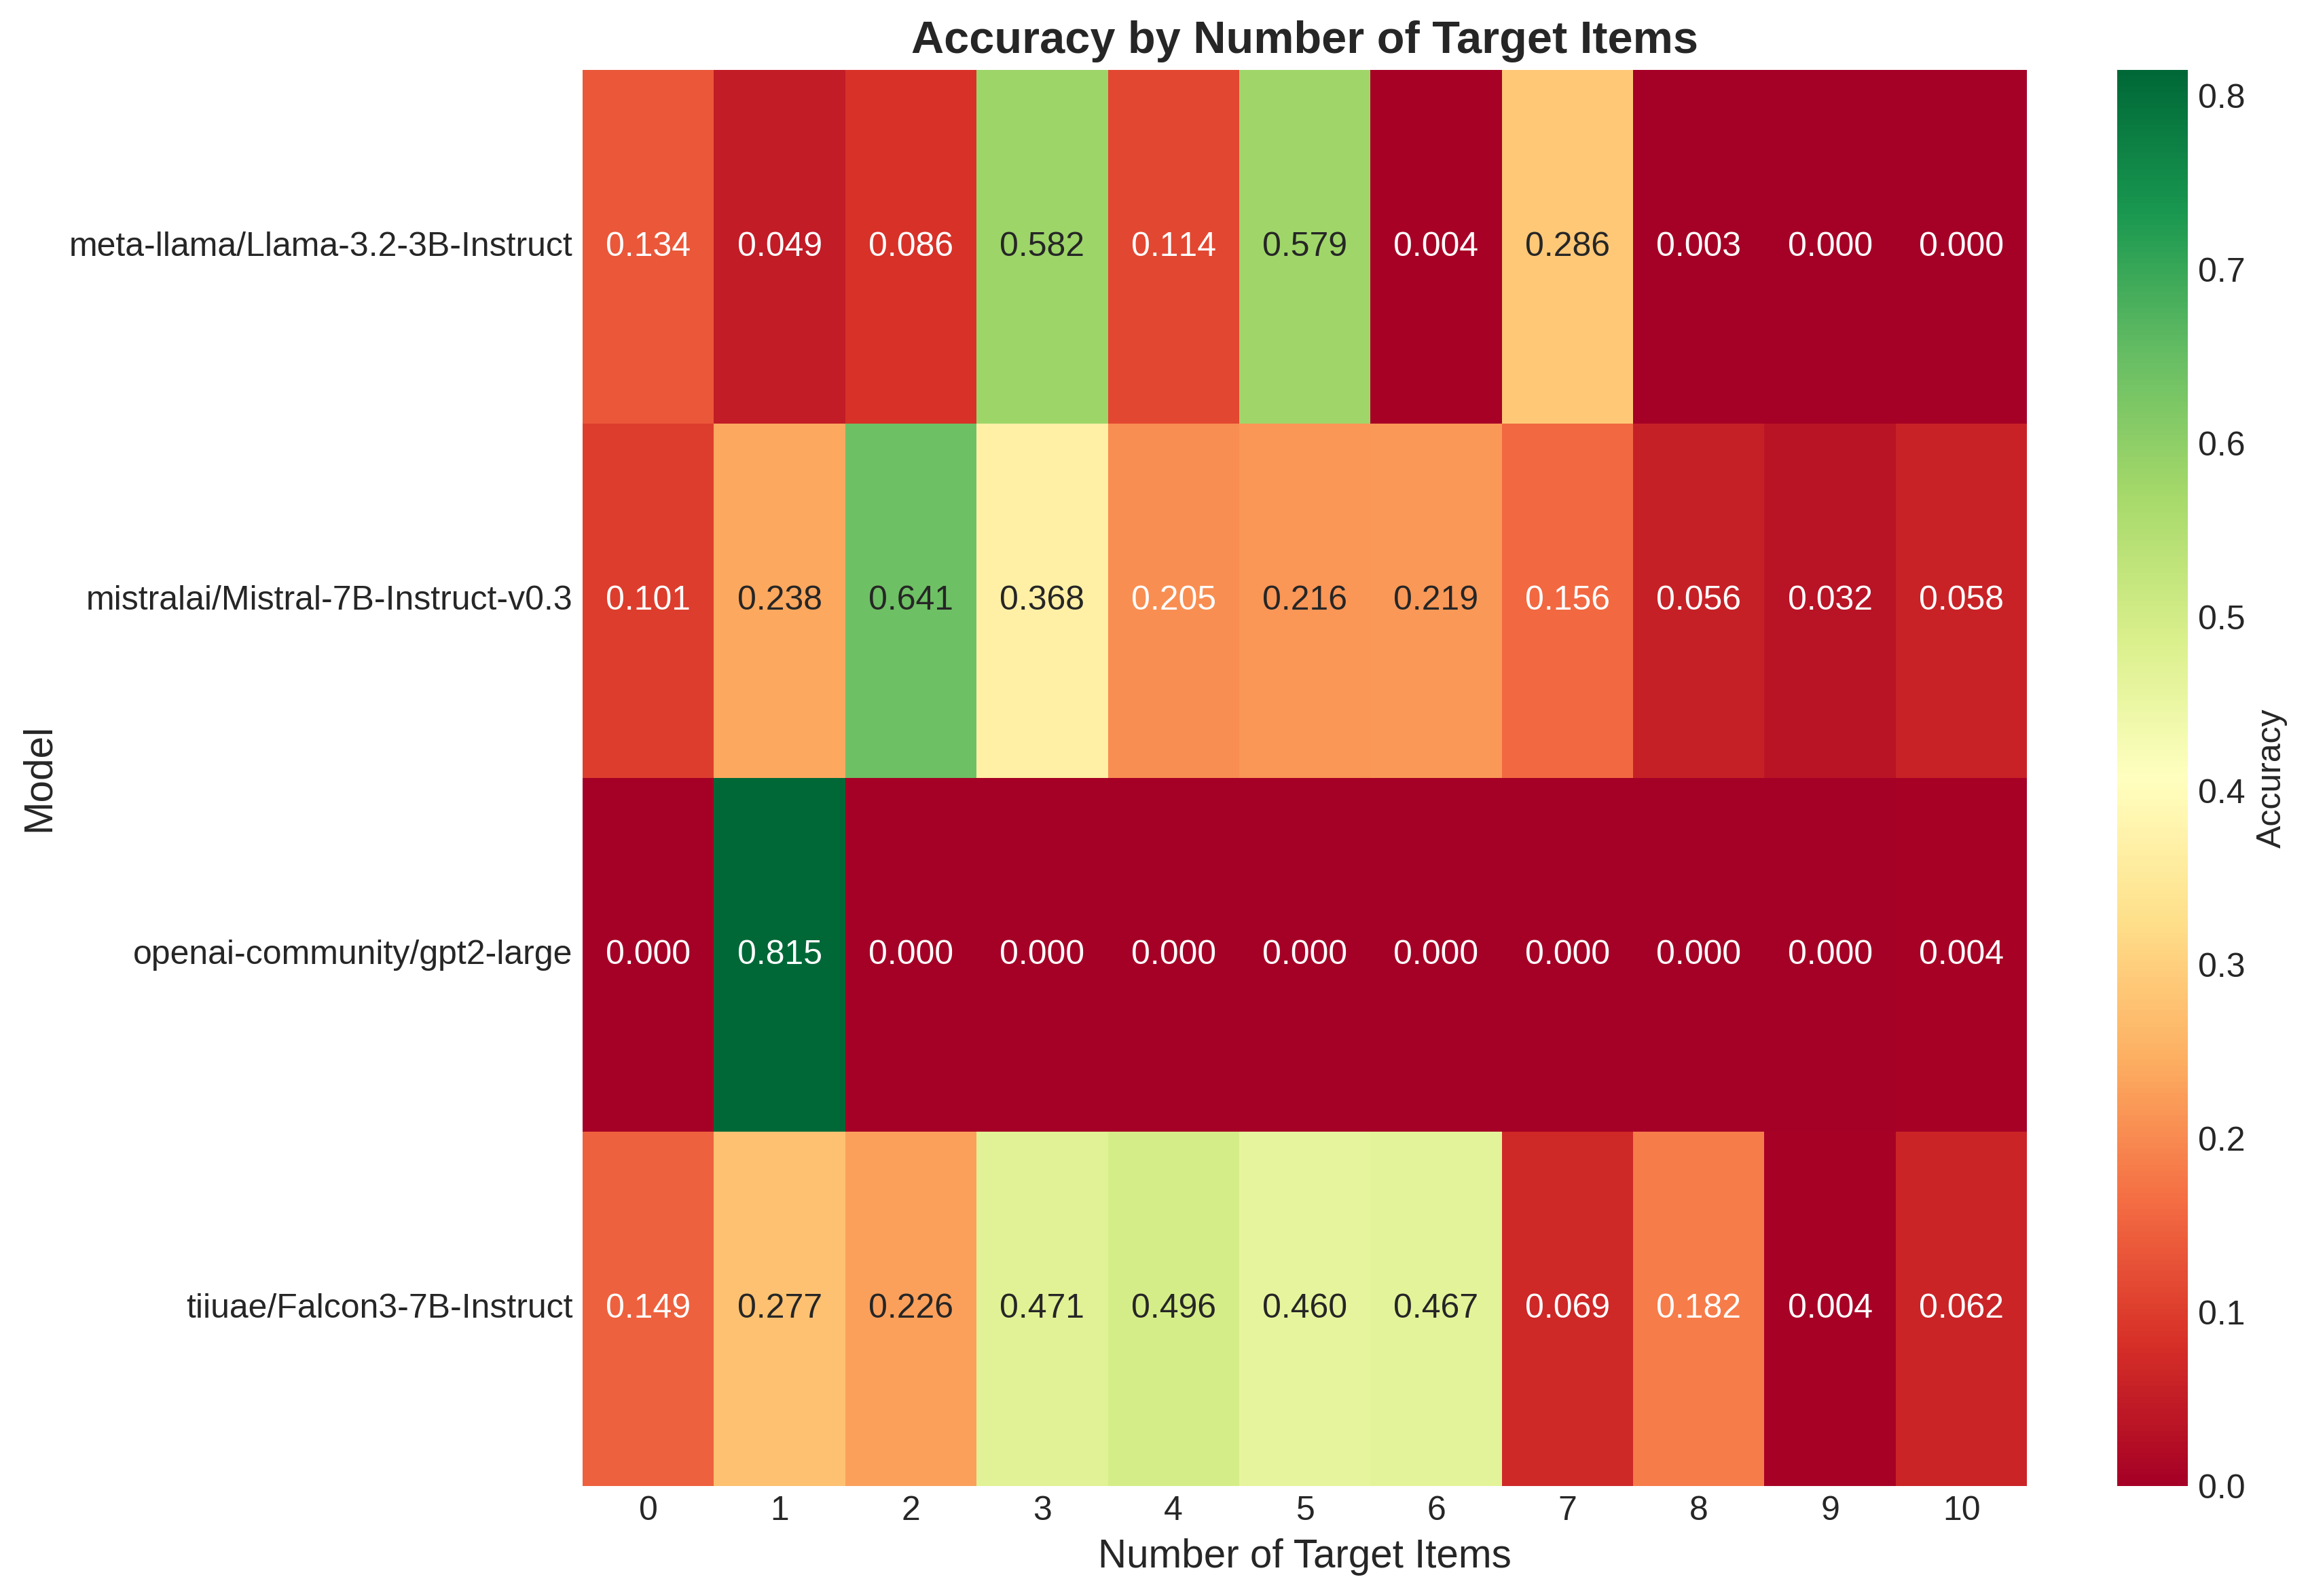


📊 Accuracy By Type 20250531 030419


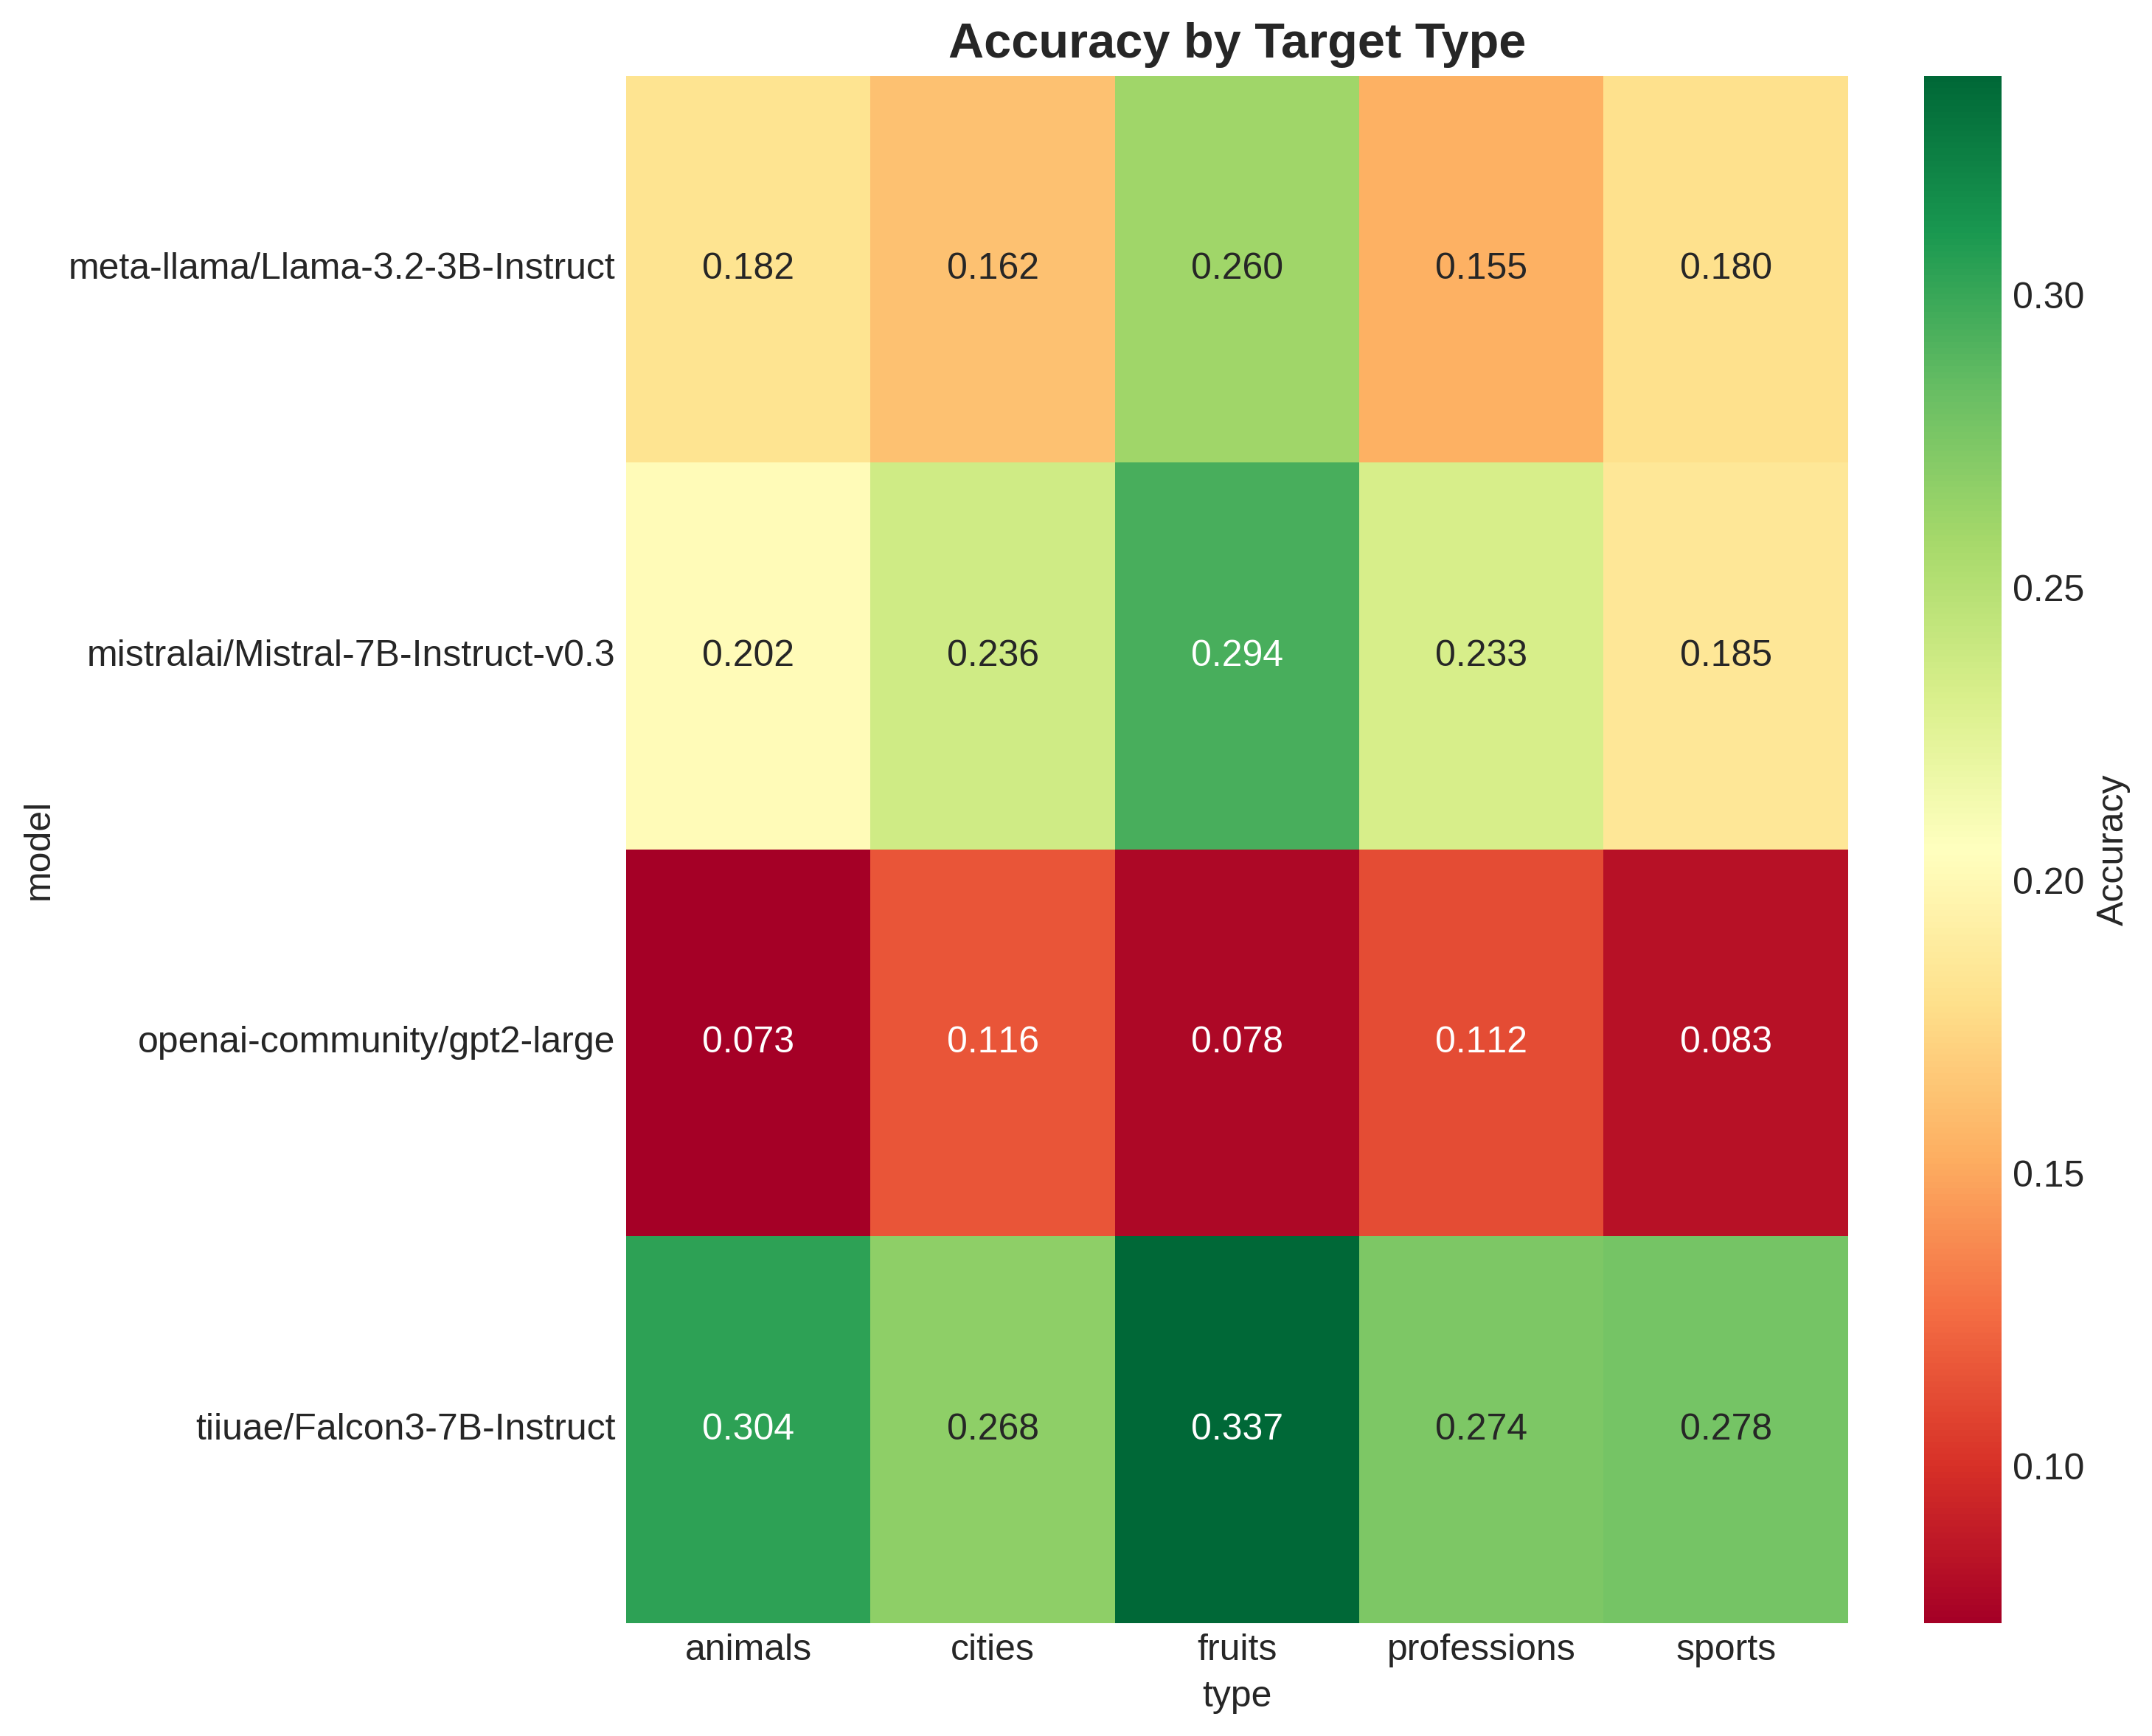


📊 Accuracy Vs List Length 20250531 030419


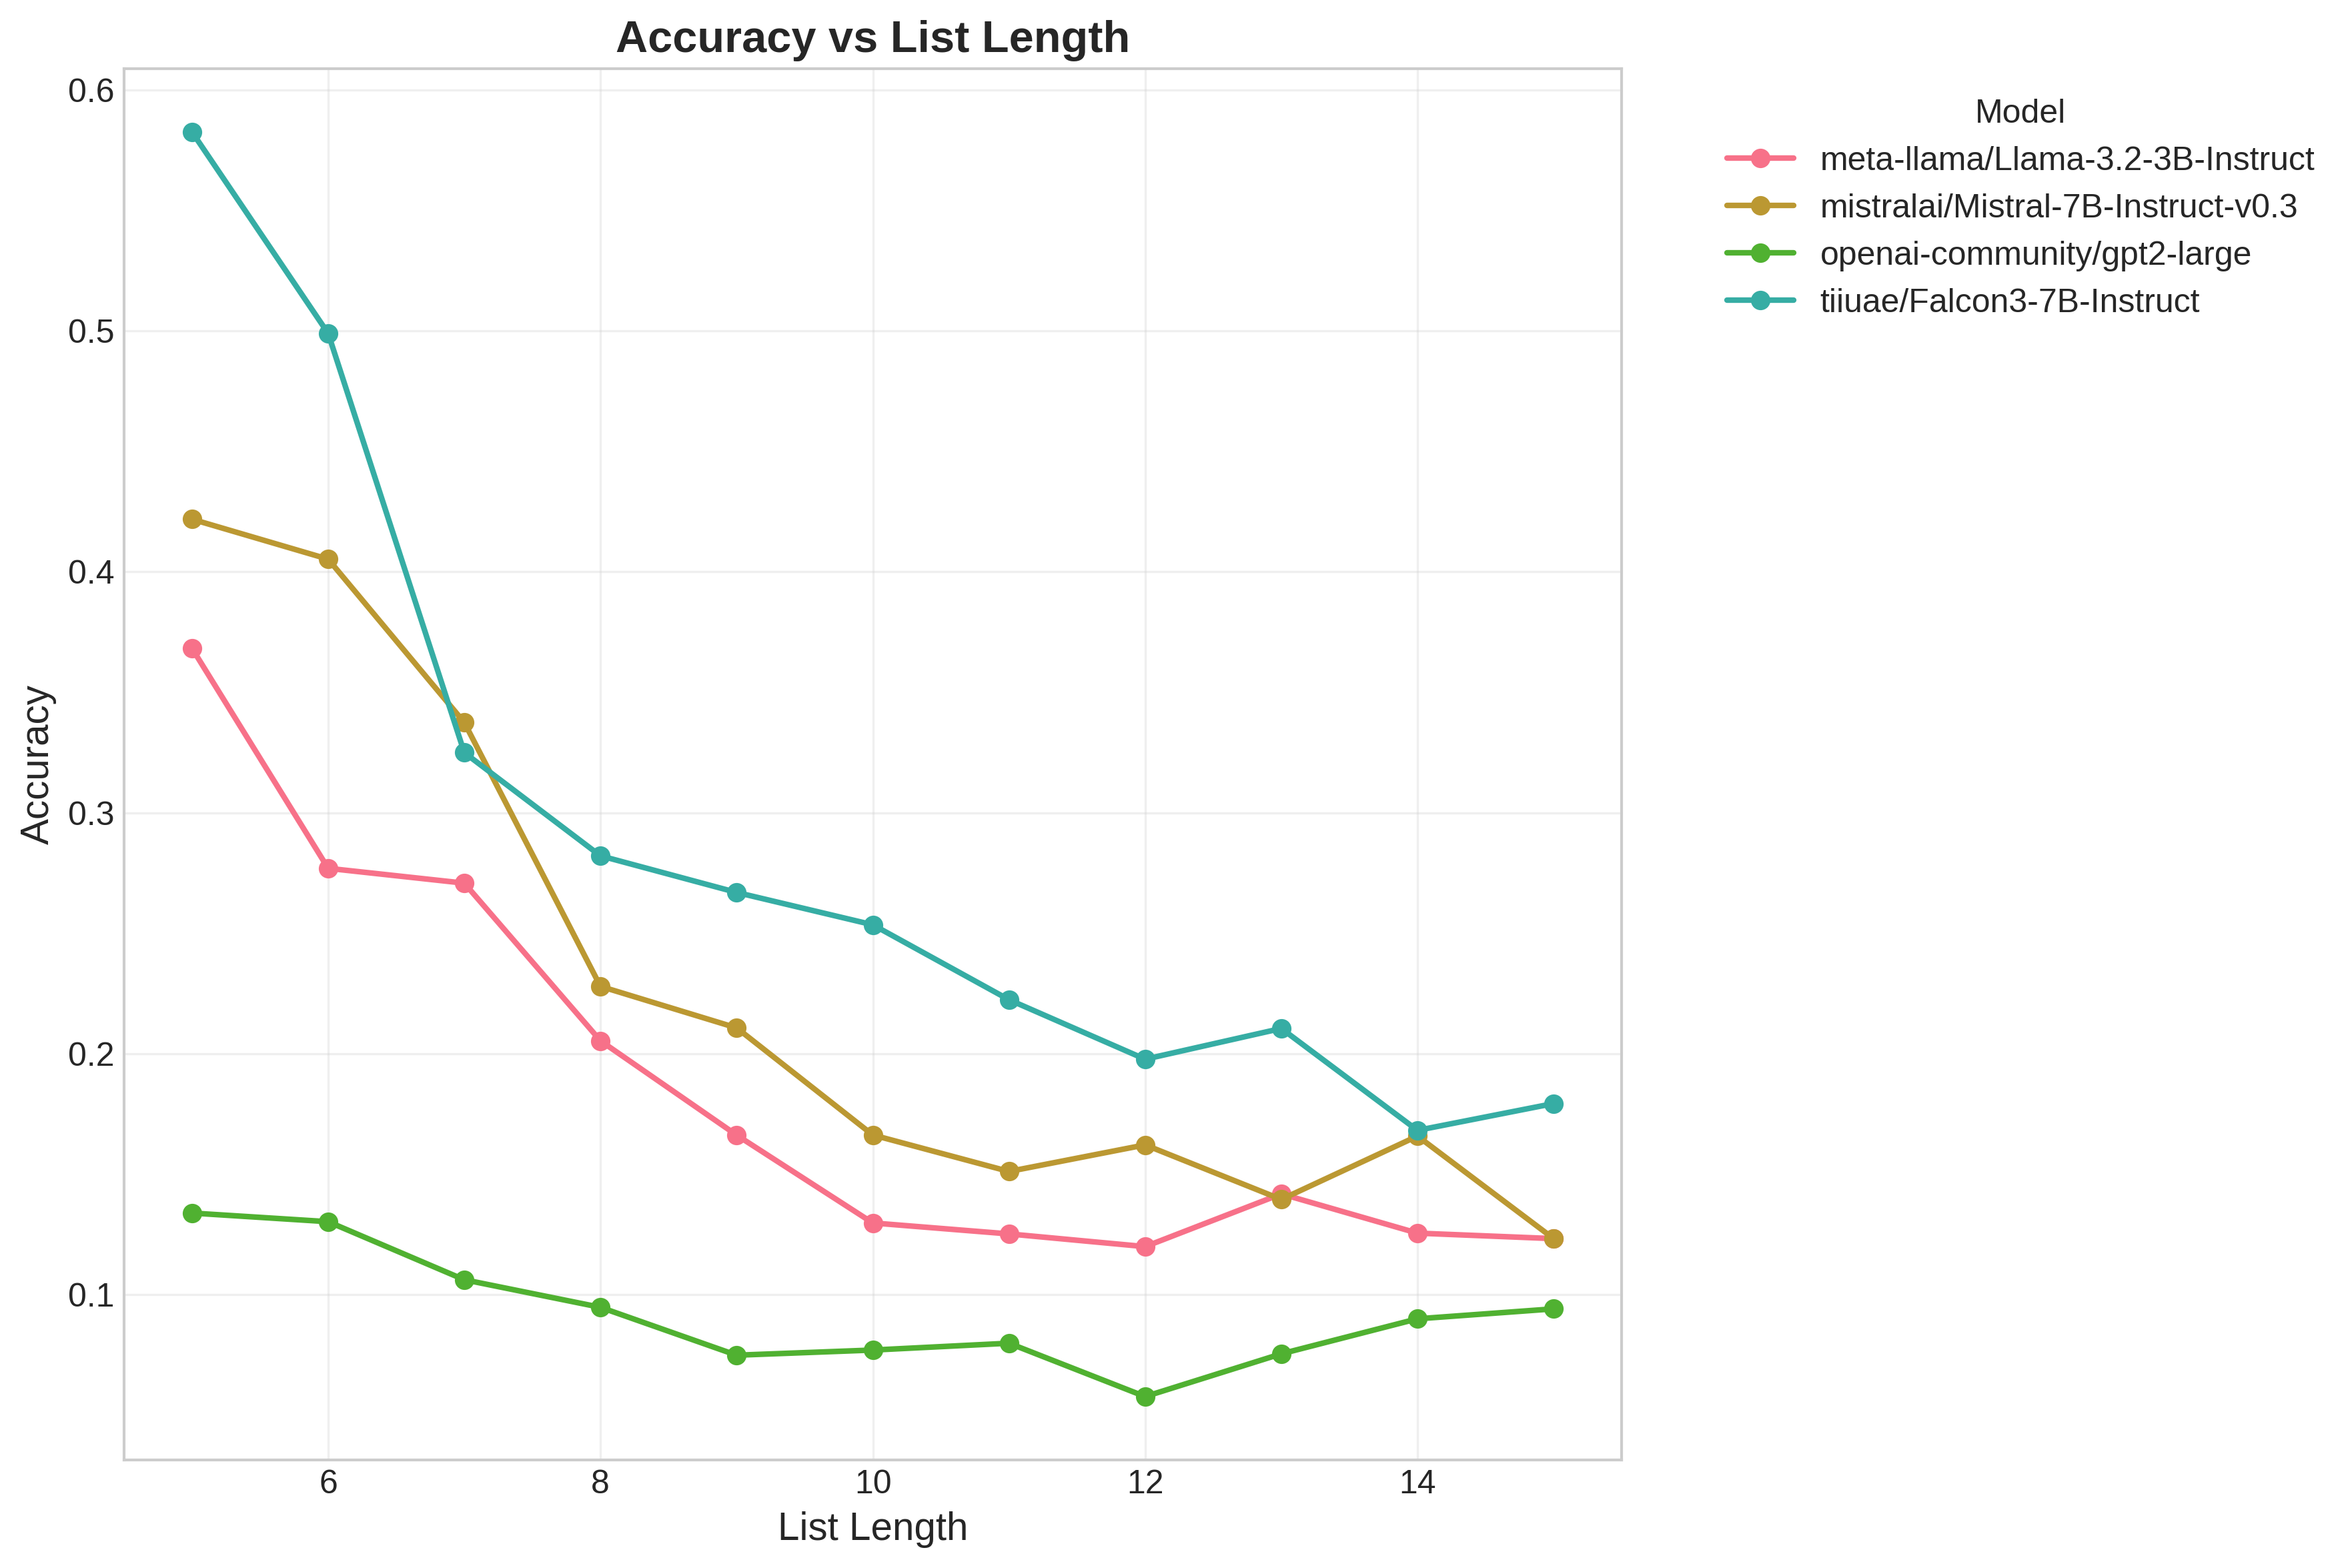


📊 Error Distribution 20250531 030419


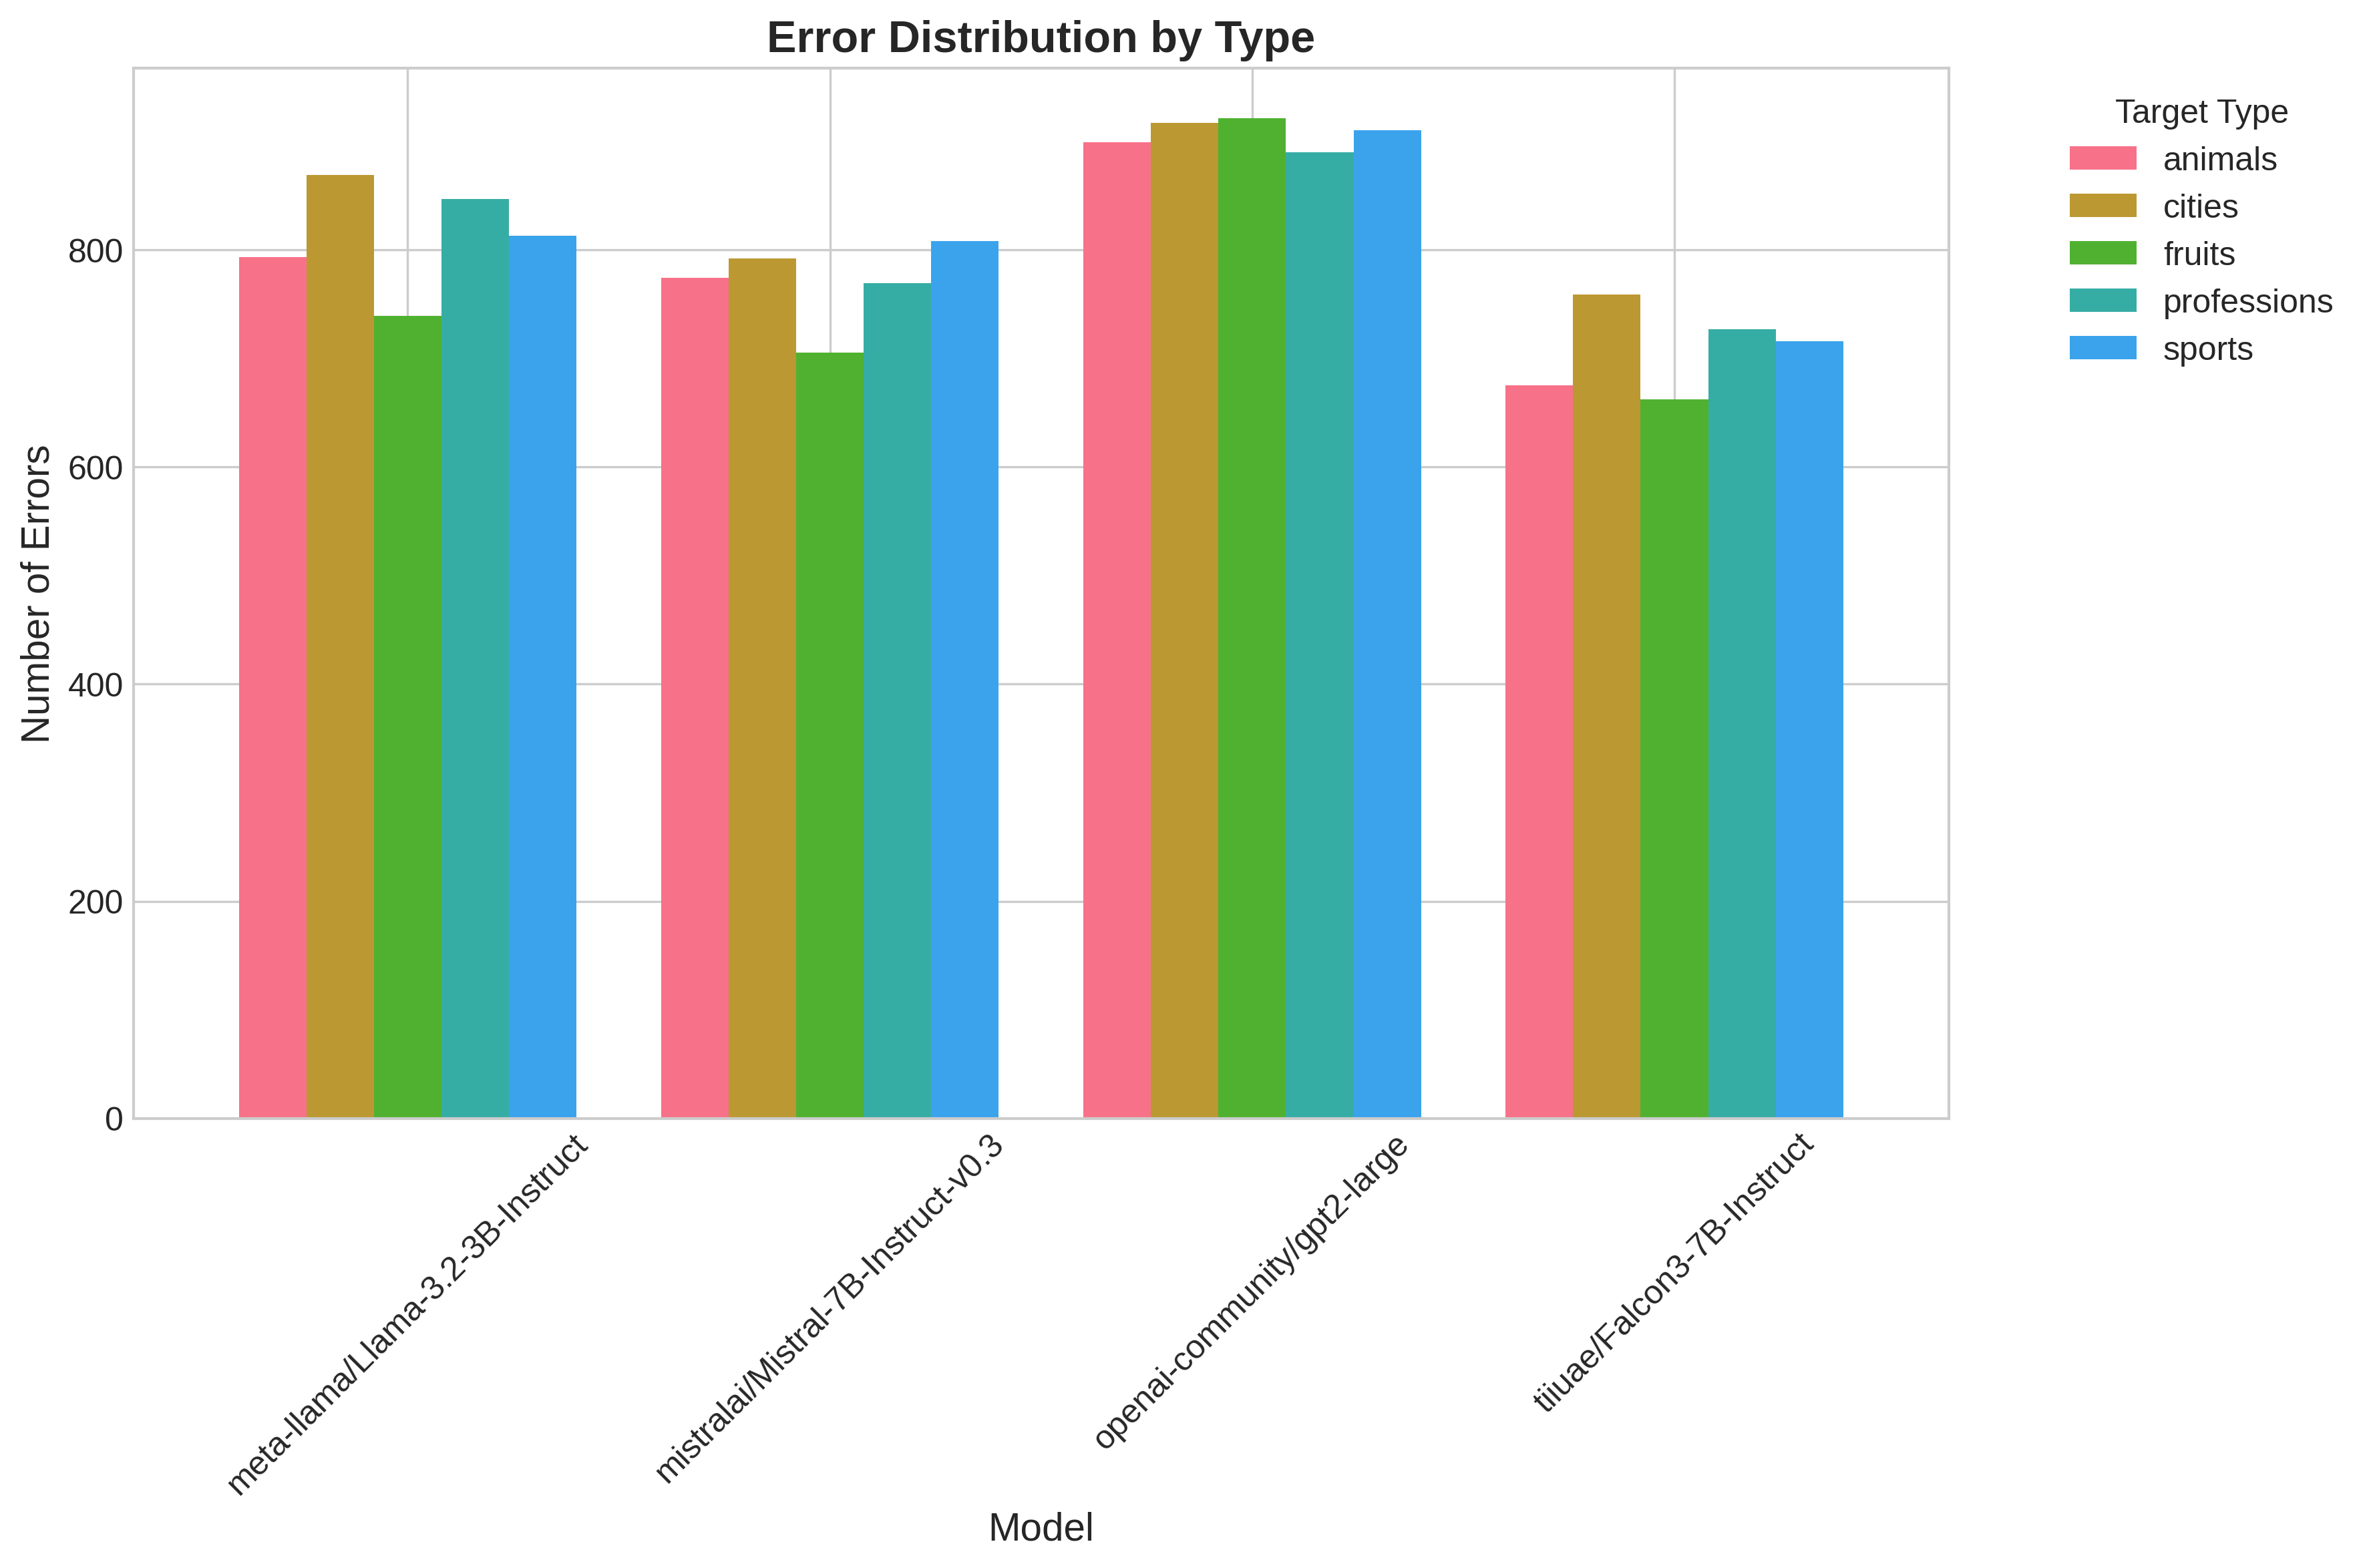


📊 Overall Accuracy 20250531 030419


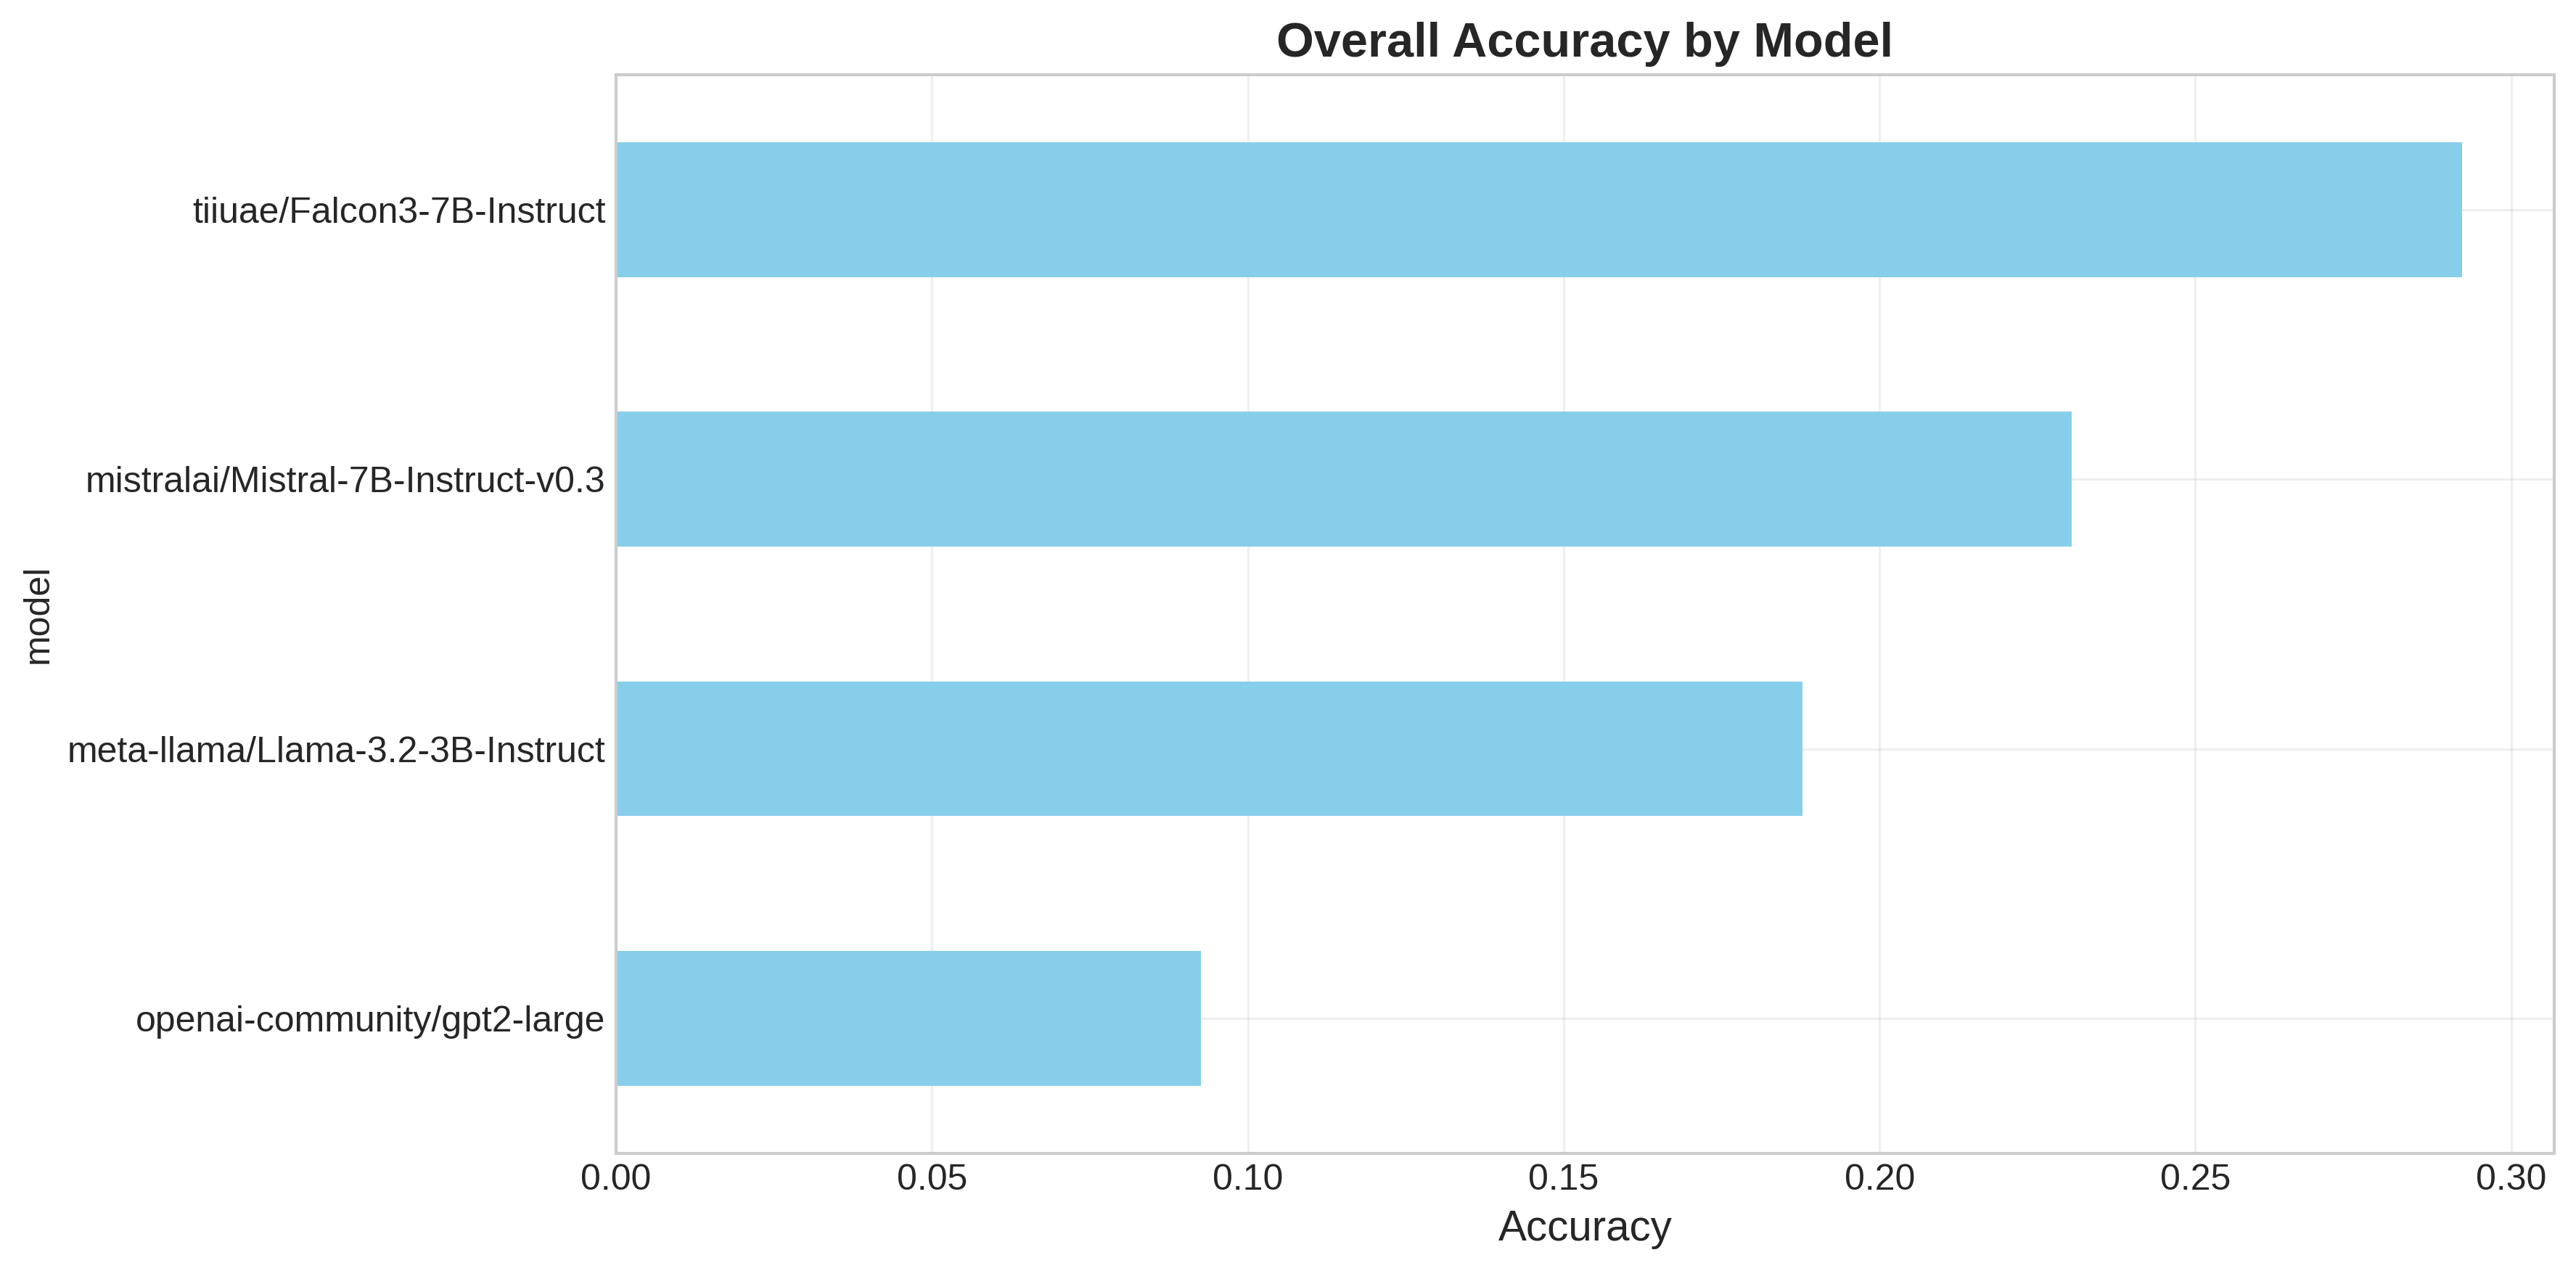


📊 Parsing Failures 20250531 030419


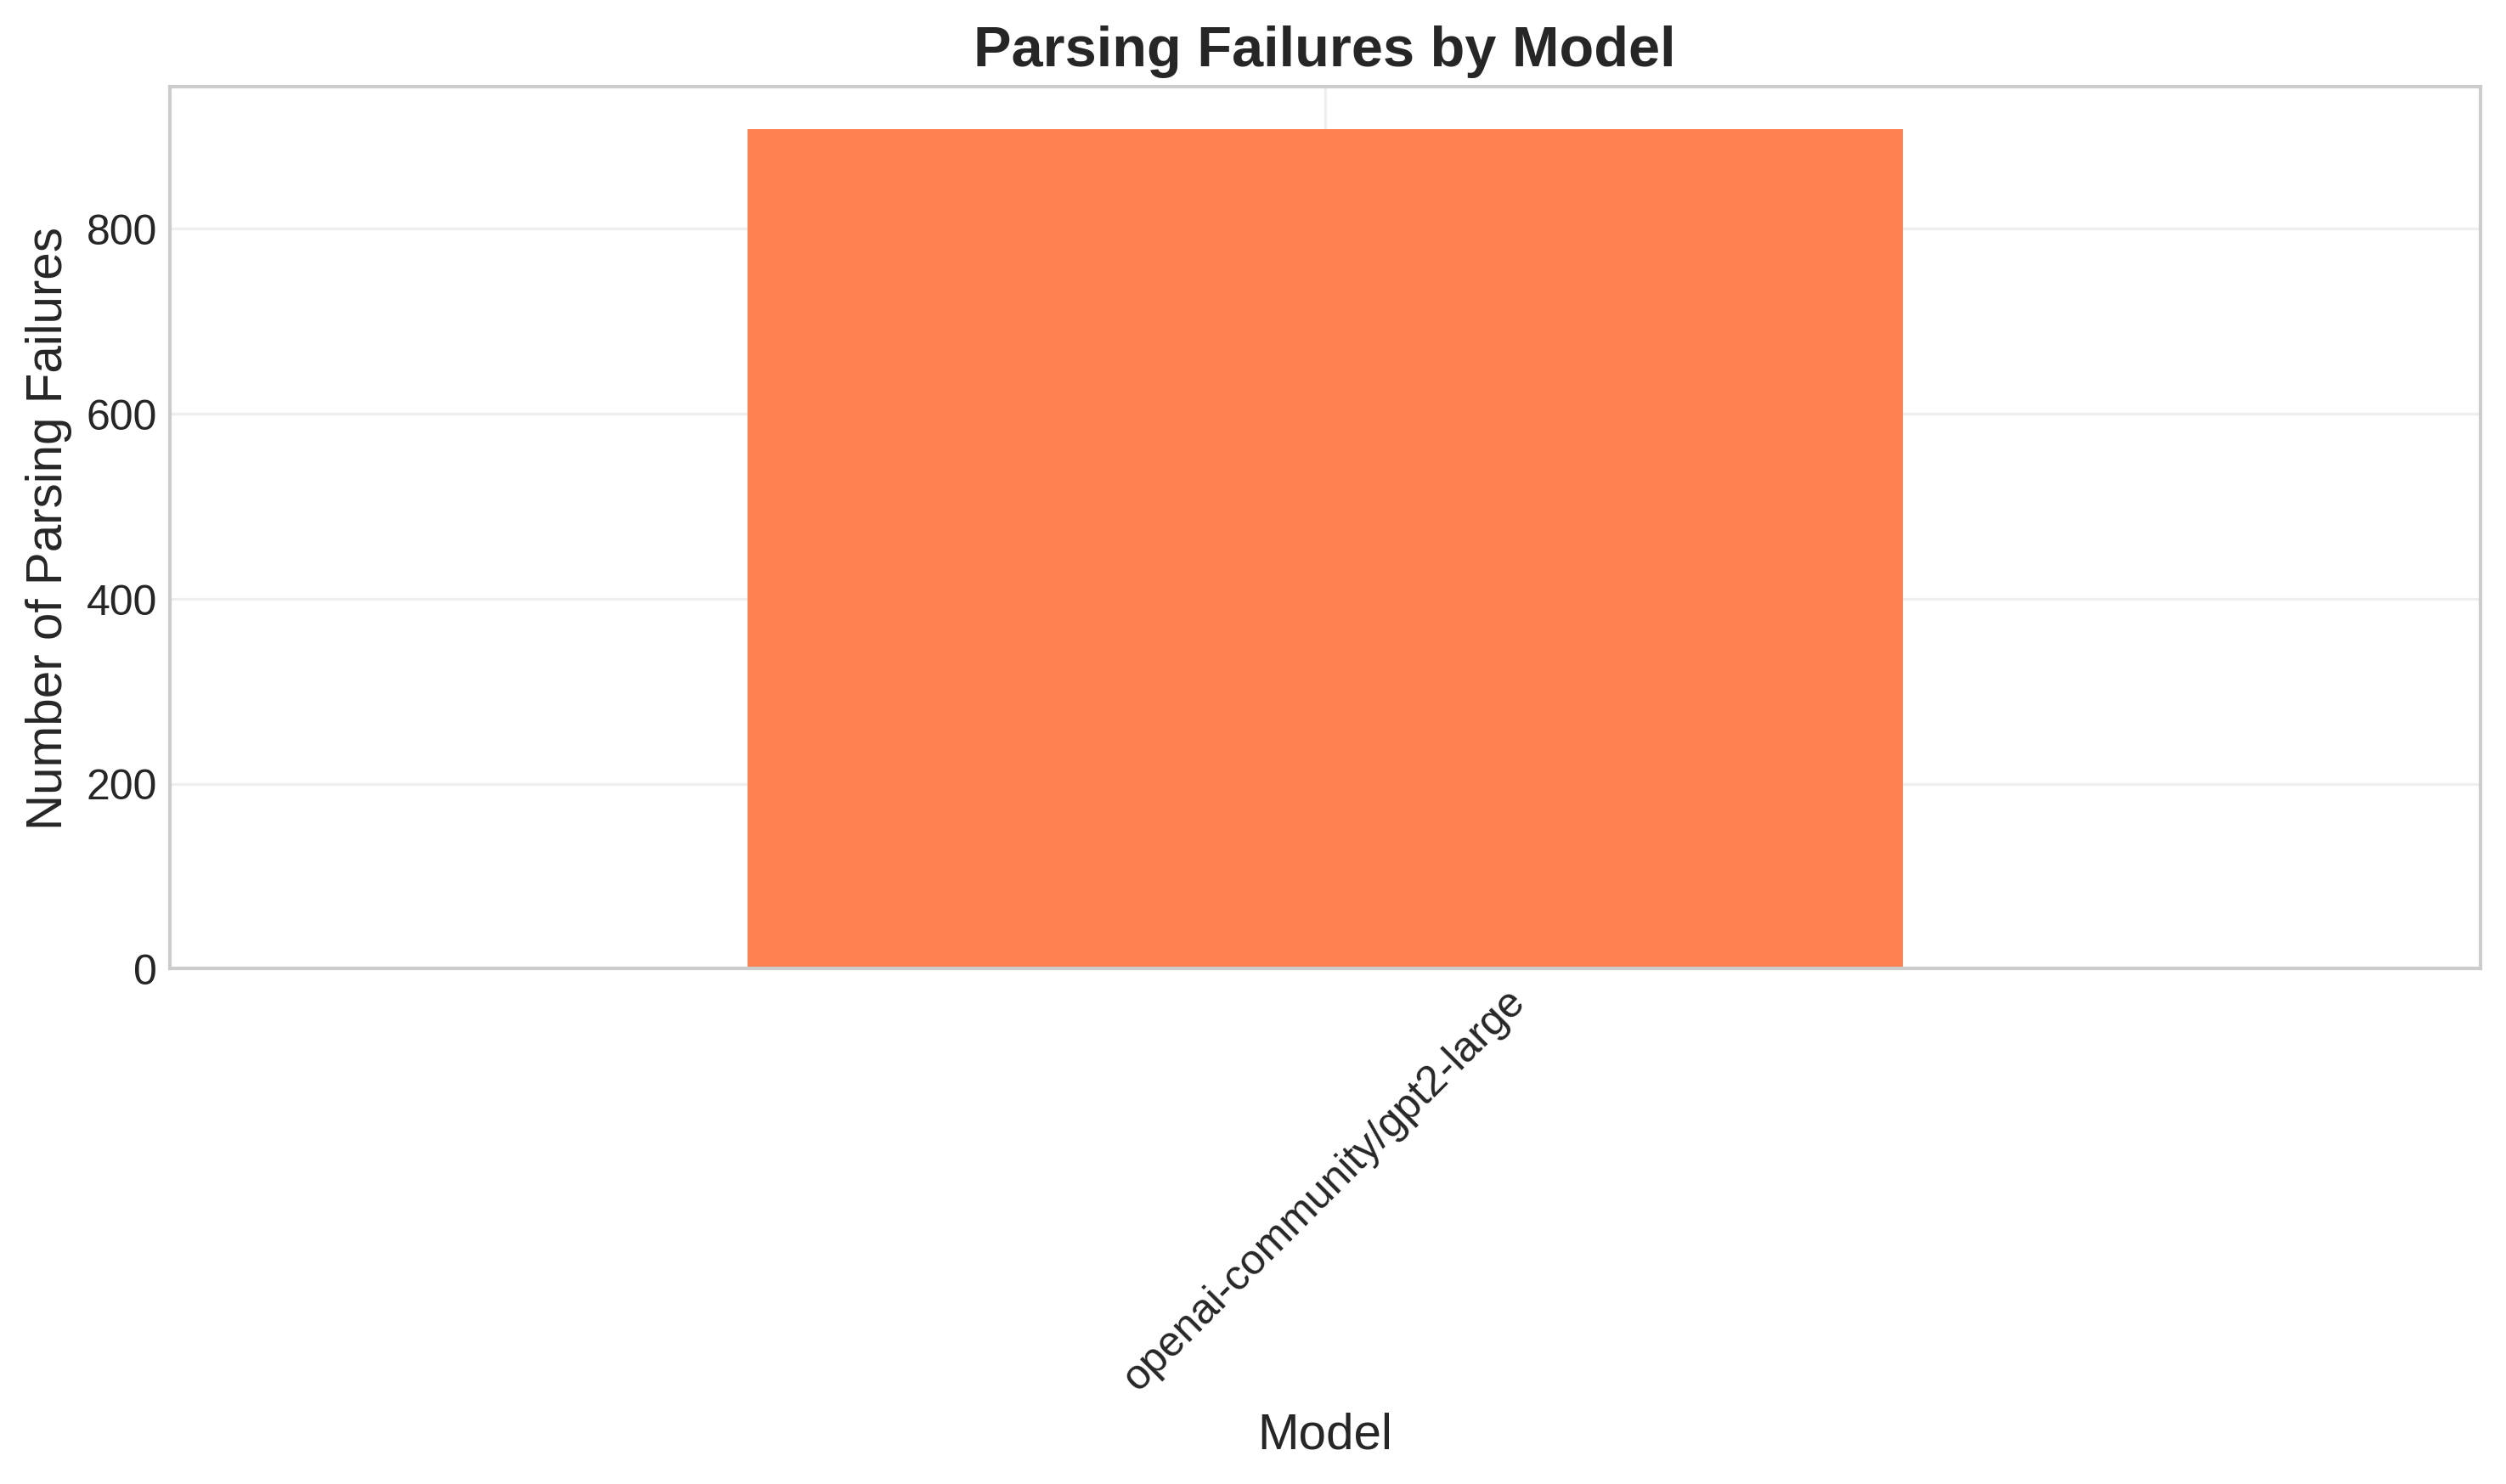

In [21]:
# Cell 2: Display all latest plots
display_saved_plots()

In [22]:
# Cell 3: List available plot types
available_plots = list_available_plots()

Available plot types:
1. accuracy_by_answer_count
2. accuracy_by_type
3. accuracy_vs_list_length
4. error_distribution
5. overall_accuracy
6. parsing_failures



📊 Overall Accuracy 20250531 030419


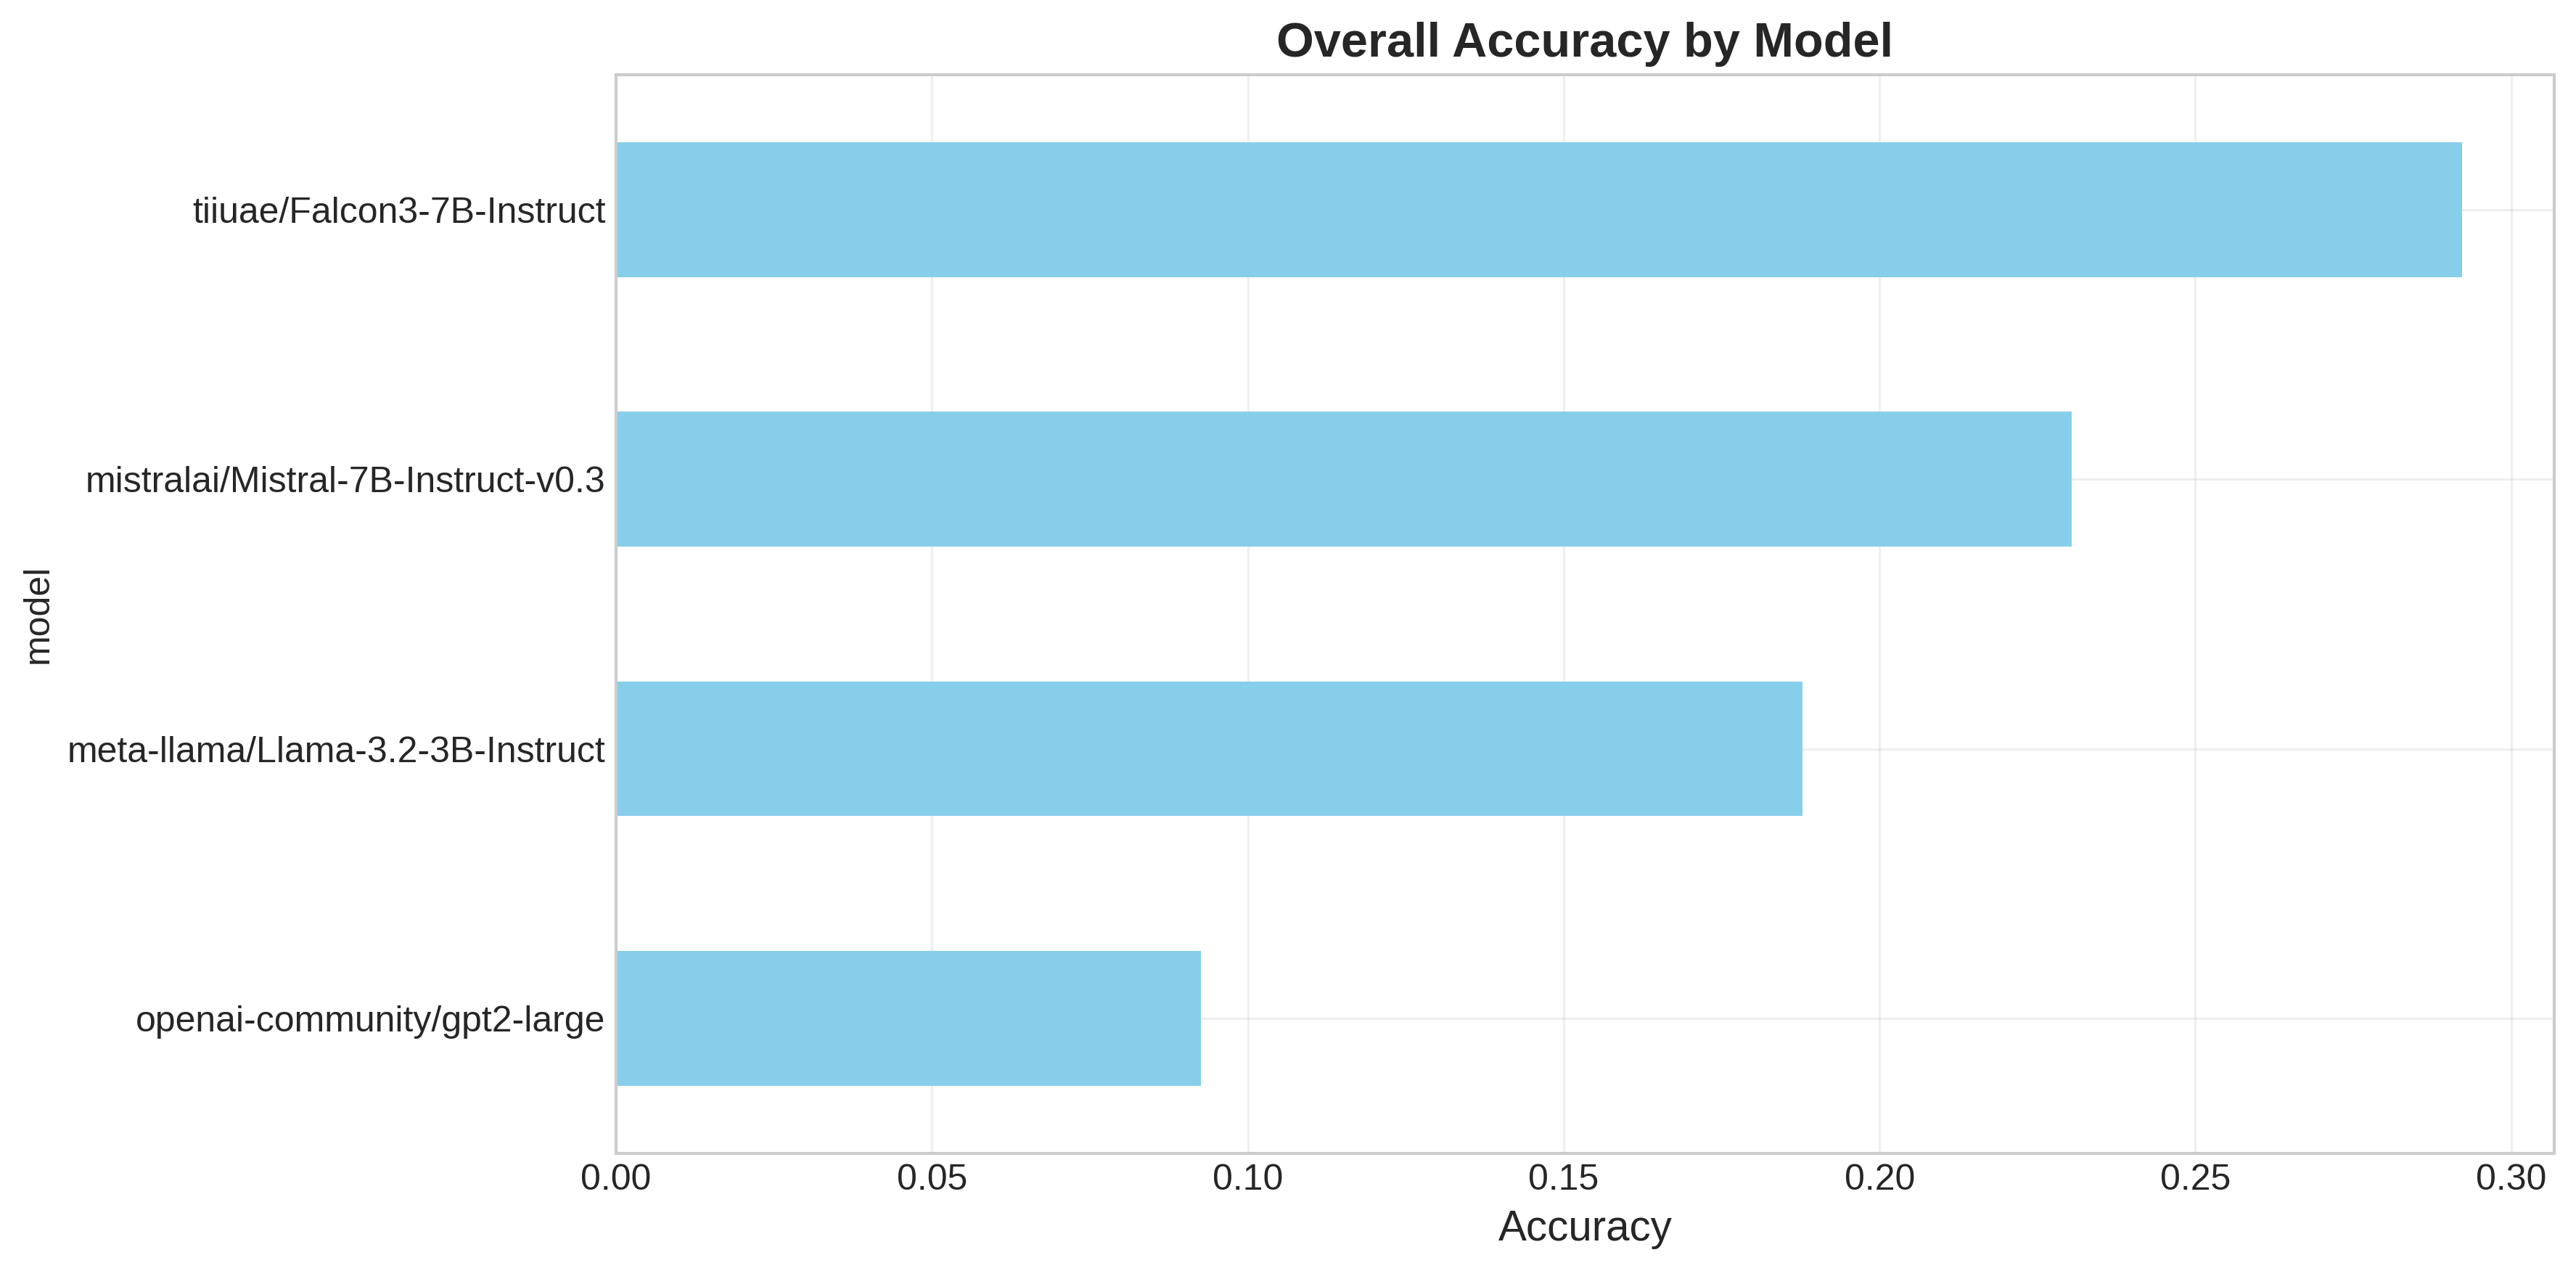

In [23]:
# Cell 4: Display specific plot type (example - overall accuracy)
display_saved_plots(plot_type='overall_accuracy')


📊 Accuracy By Type 20250531 030419


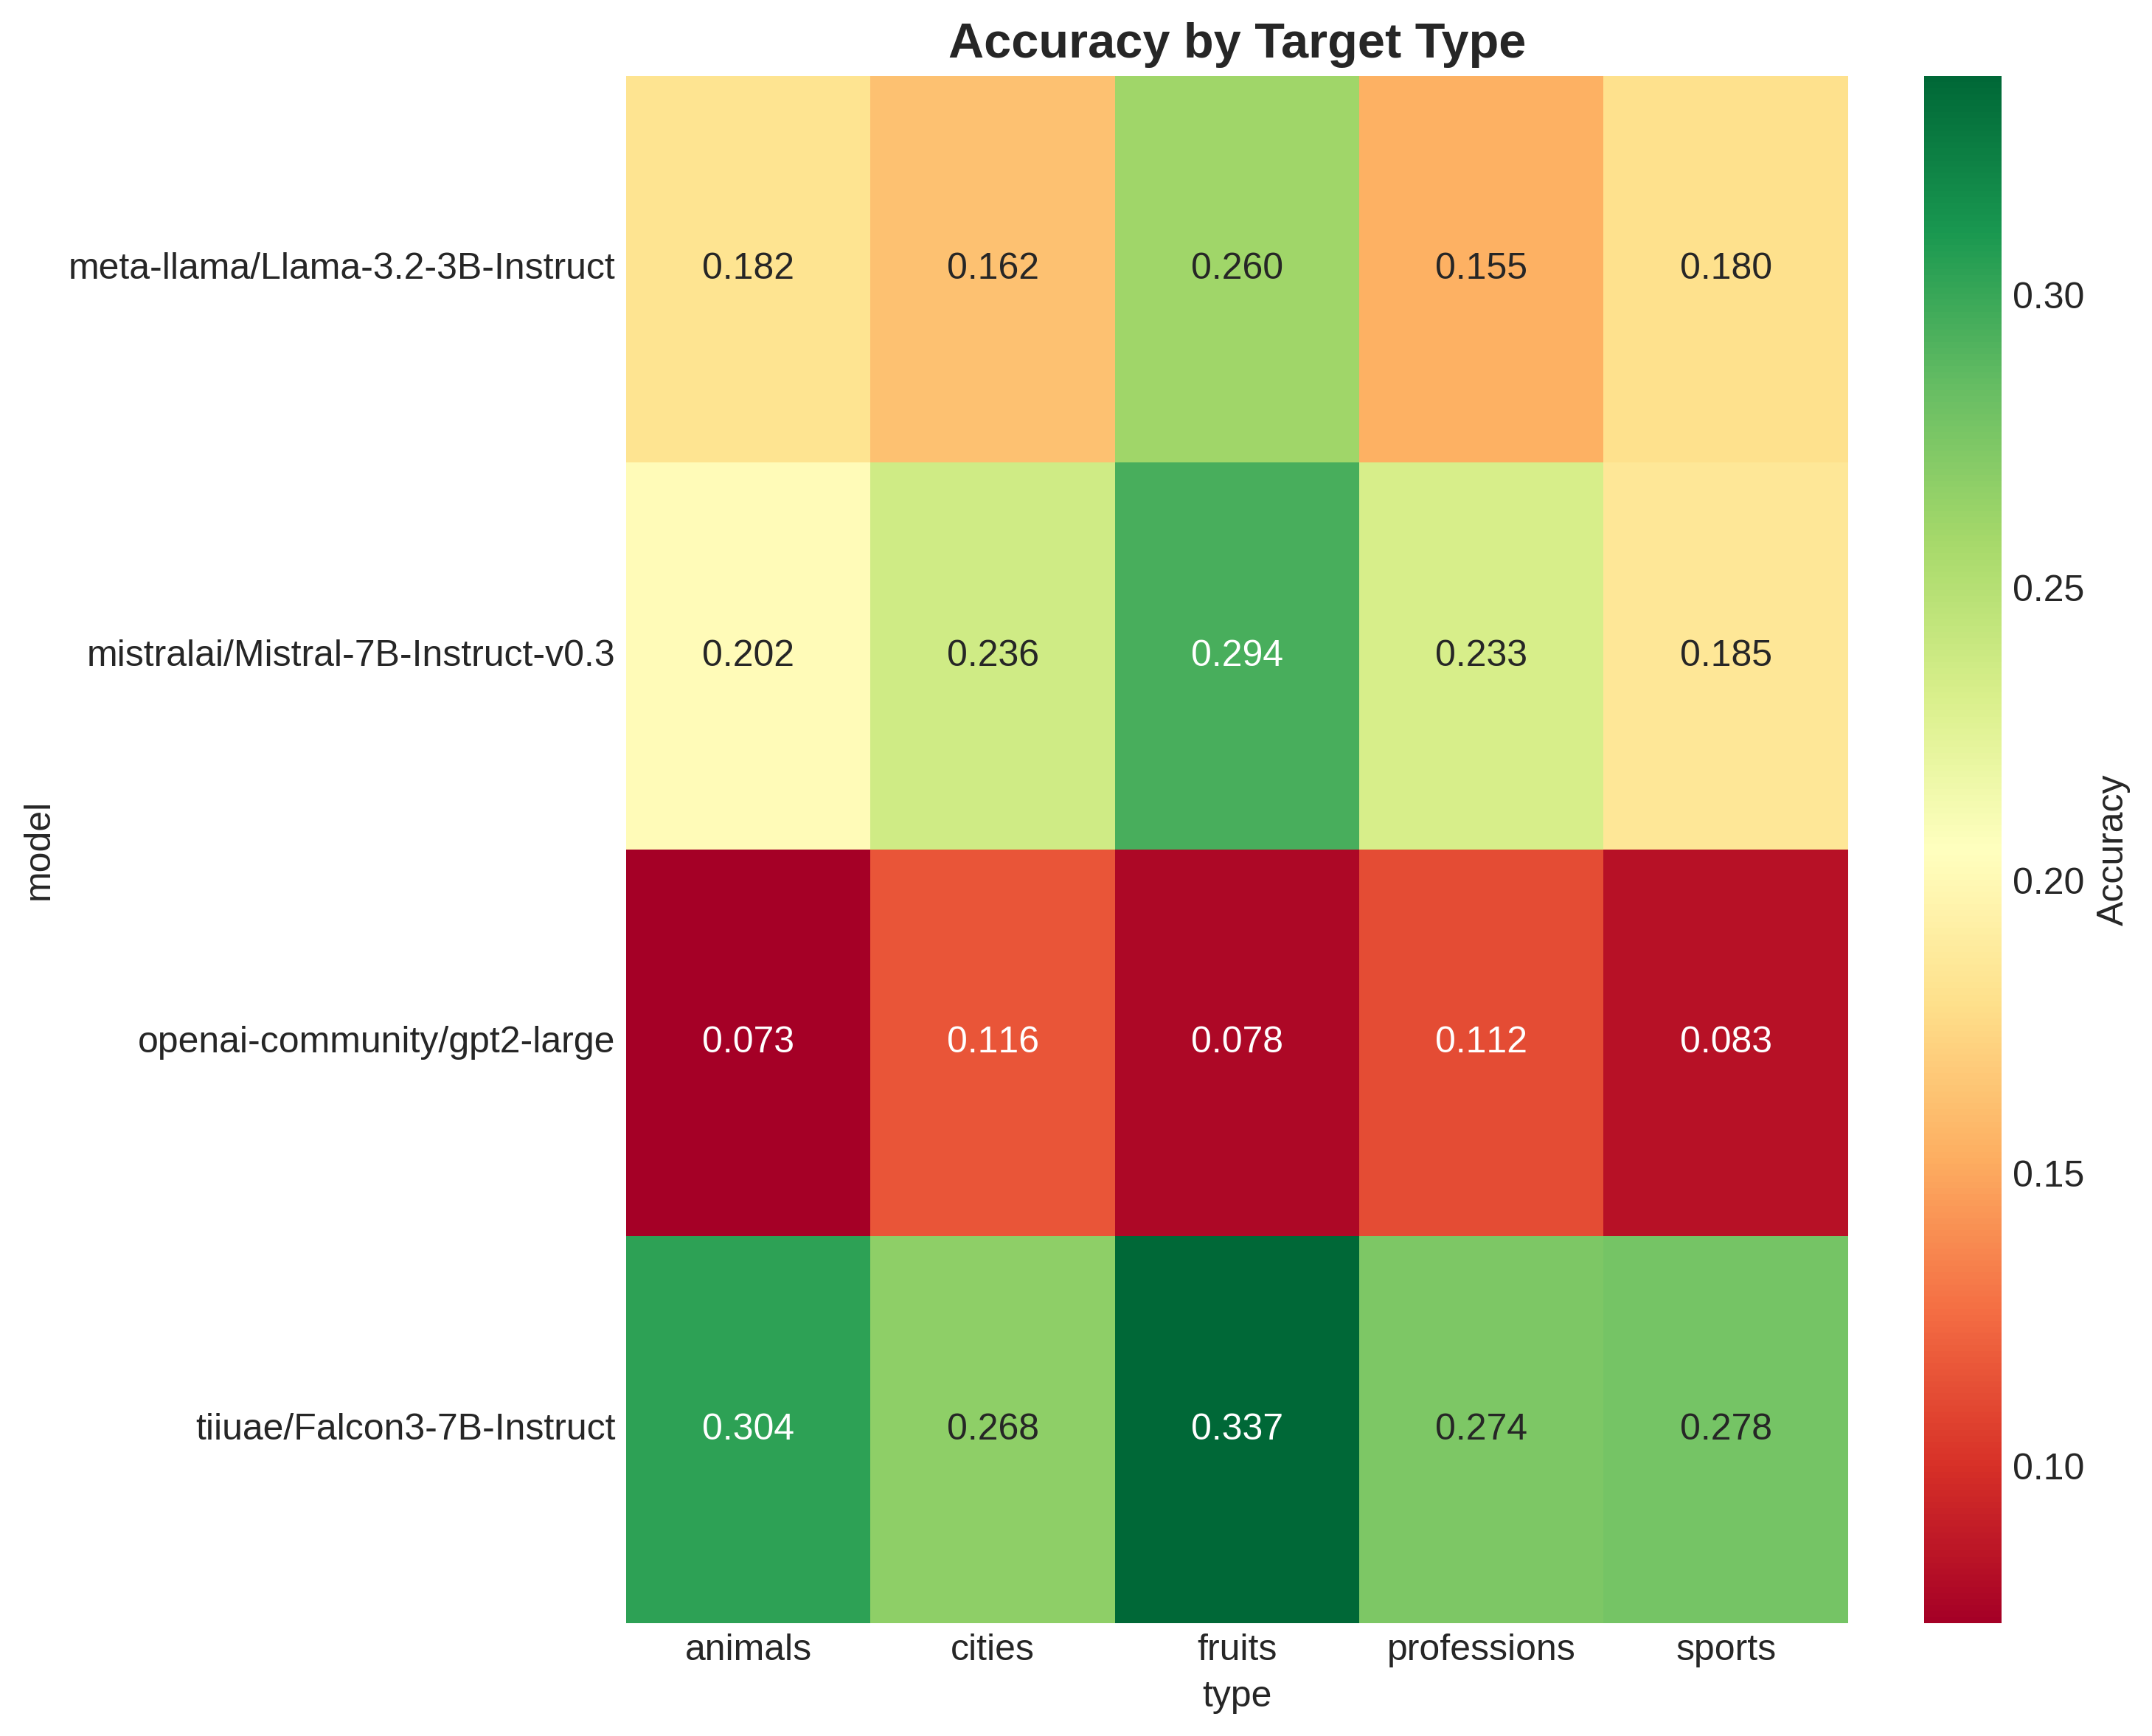

In [24]:
# Cell 5: Display specific plot type (example - accuracy by type)
display_saved_plots(plot_type='accuracy_by_type')


📊 Accuracy Vs List Length 20250531 030419


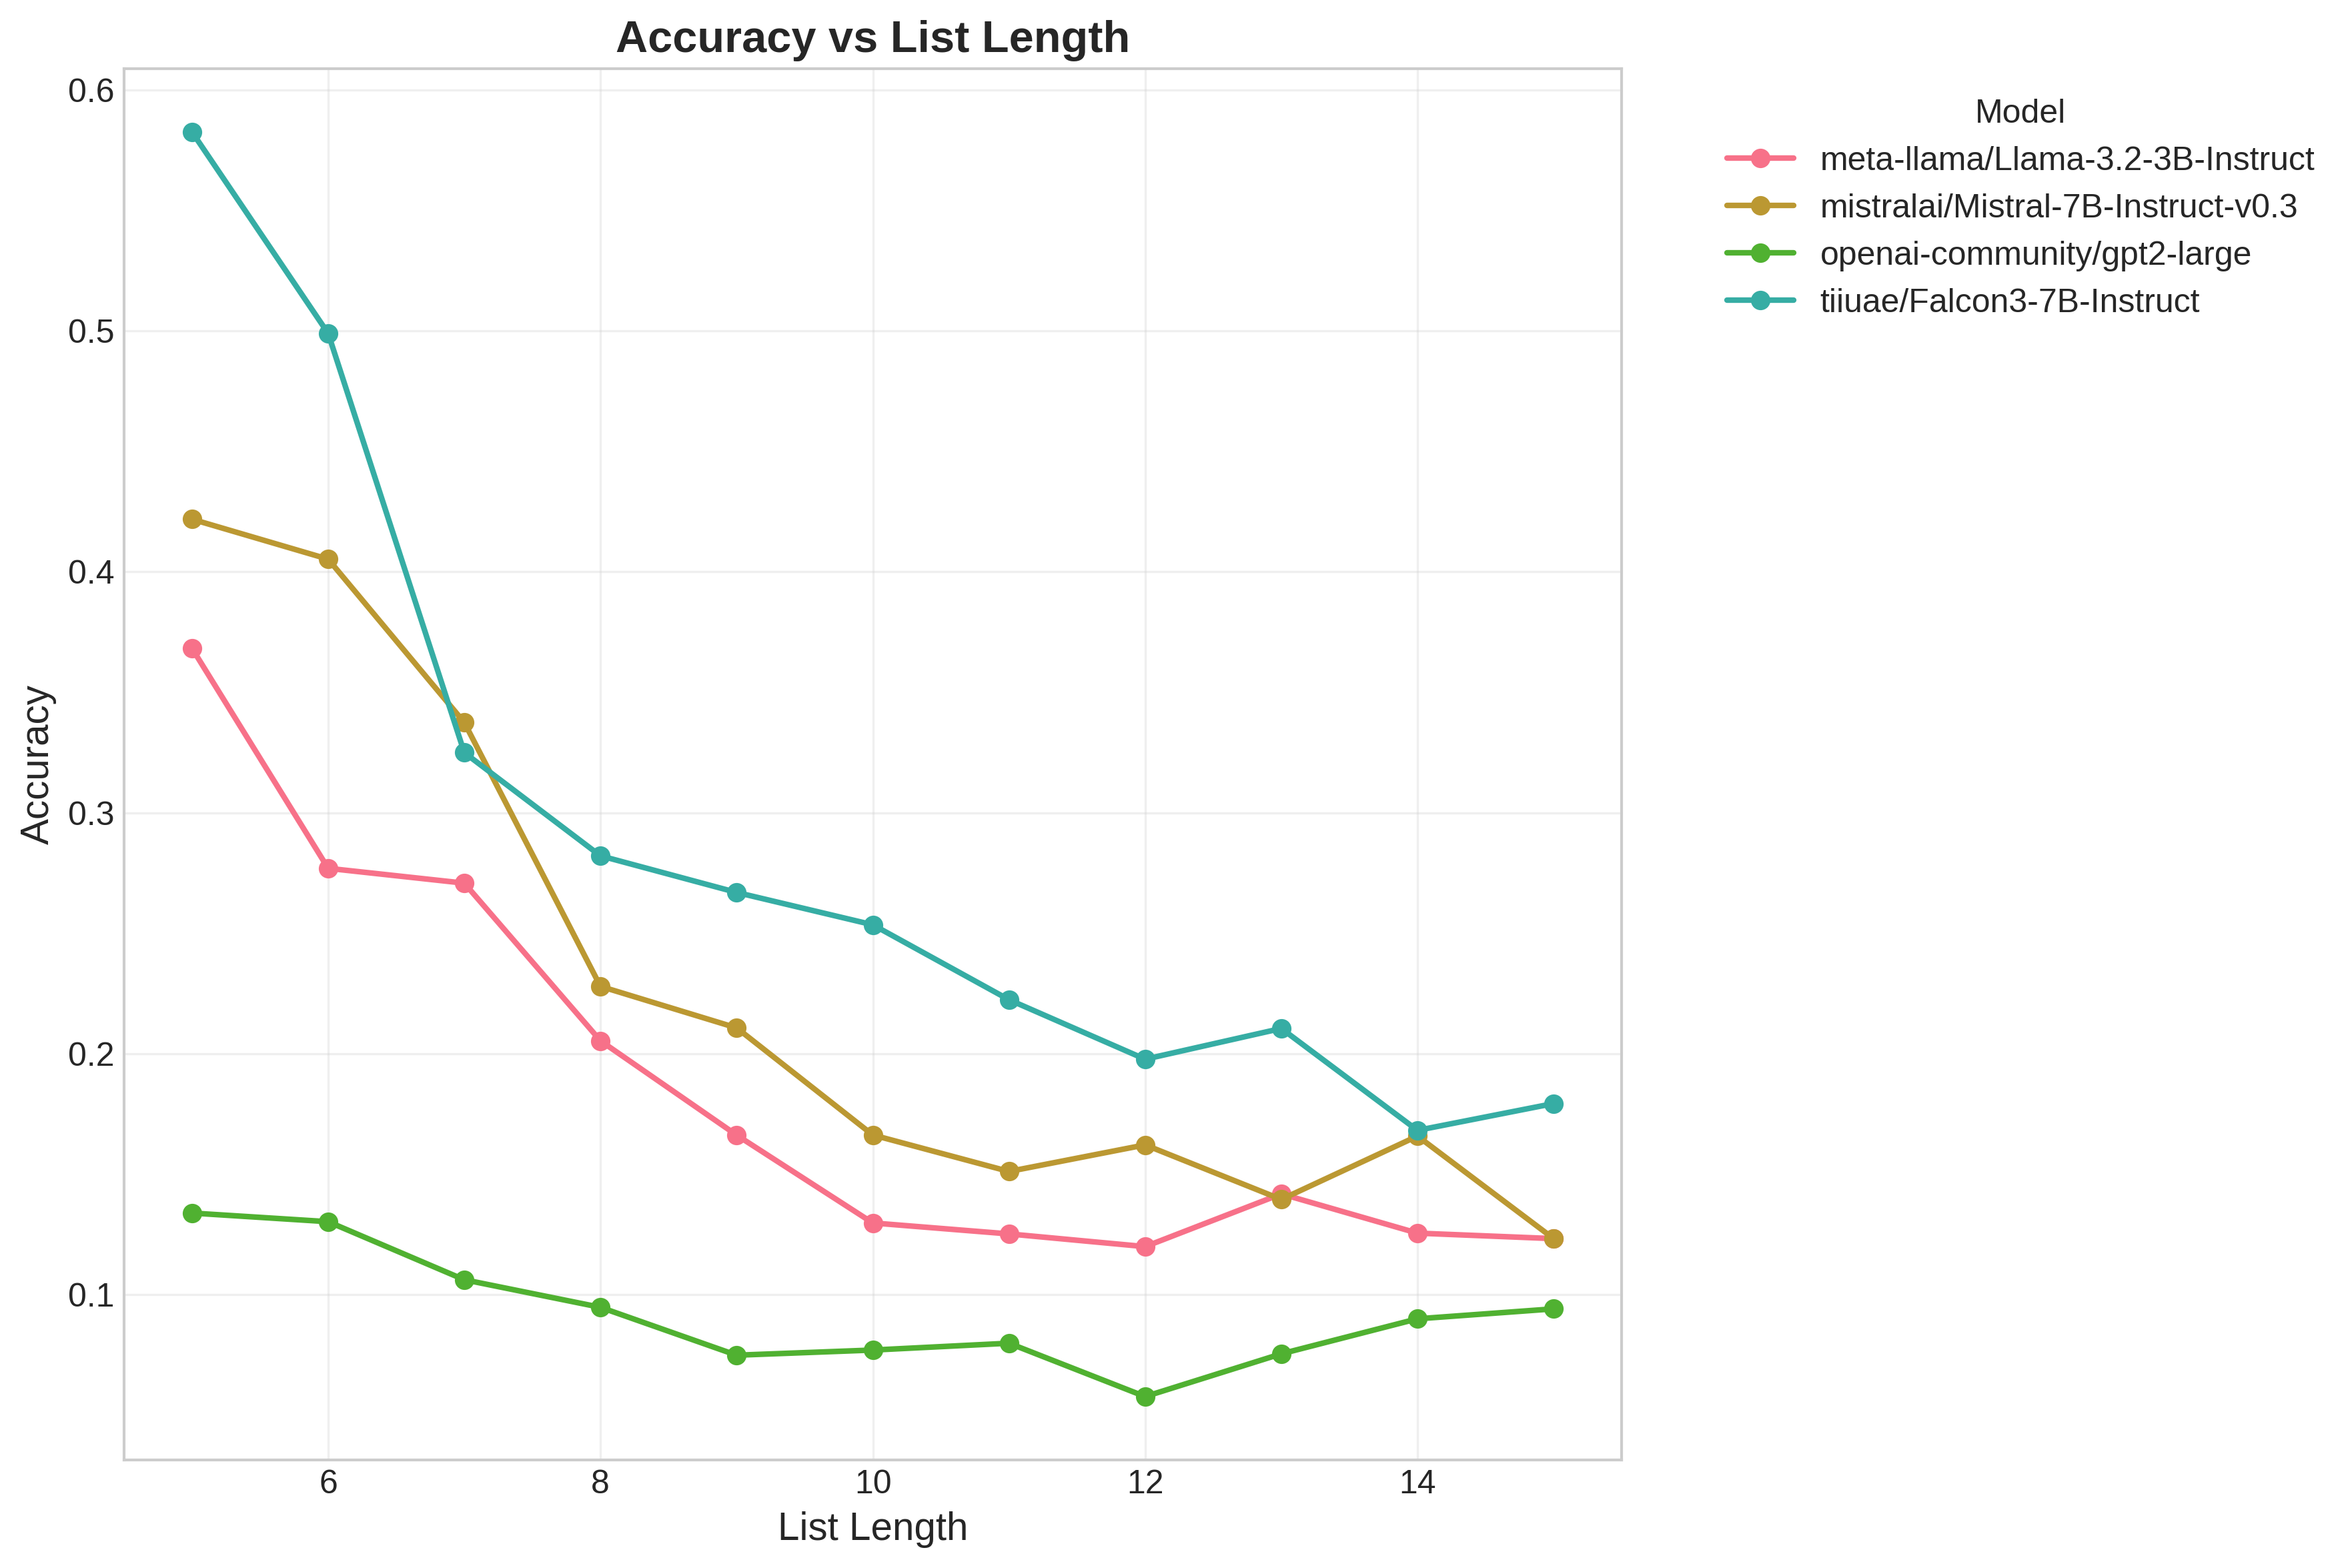

In [25]:
display_saved_plots(plot_type='accuracy_vs_list_length')

In [ ]:
# Cell 6: Display all versions of all plots (not just latest)
# display_saved_plots(latest_only=False)

In [ ]:
# Cell 7: Quick display function for single plots
def show_plot(plot_name):
    """Quick function to display a specific plot"""
    display_saved_plots(plot_type=plot_name)

# Usage examples:
# show_plot('overall_accuracy')
# show_plot('accuracy_by_answer_count')
# show_plot('error_distribution')